In [1]:
from google.colab import files
files.upload()  # Select the kaggle.json file
# Upload a file named: kaggle.json
# Copy paste the following into it: {"username":"muhammadzaeemrizwan","key":"74b9d065fbe470950f21c48f97e58fe9"}

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadzaeemrizwan","key":"74b9d065fbe470950f21c48f97e58fe9"}'}

In [2]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d muhammadzaeemrizwan/doubledataset
!kaggle datasets download -d muhammadzaeemrizwan/doubledataloaders

Dataset URL: https://www.kaggle.com/datasets/muhammadzaeemrizwan/doubledataset
License(s): unknown
100% 1.24G/1.24G [00:57<00:00, 24.4MB/s]
100% 1.24G/1.24G [00:57<00:00, 23.2MB/s]
Dataset URL: https://www.kaggle.com/datasets/muhammadzaeemrizwan/doubledataloaders
License(s): unknown
100% 197k/197k [00:00<00:00, 396kB/s]
100% 197k/197k [00:00<00:00, 396kB/s]


In [4]:
!unzip doubledataset.zip -d /content/doubledataset
!unzip doubledataloaders.zip -d /content/doubledataloaders

Streaming output truncated to the last 5000 lines.
  inflating: /content/doubledataset/domain/sketch/barn/sketch_016_000092.jpg  
  inflating: /content/doubledataset/domain/sketch/barn/sketch_016_000093.jpg  
  inflating: /content/doubledataset/domain/sketch/barn/sketch_016_000094.jpg  
  inflating: /content/doubledataset/domain/sketch/barn/sketch_016_000095.jpg  
  inflating: /content/doubledataset/domain/sketch/barn/sketch_016_000096.jpg  
  inflating: /content/doubledataset/domain/sketch/barn/sketch_016_000097.jpg  
  inflating: /content/doubledataset/domain/sketch/barn/sketch_016_000098.jpg  
  inflating: /content/doubledataset/domain/sketch/barn/sketch_016_000099.jpg  
  inflating: /content/doubledataset/domain/sketch/barn/sketch_016_000100.jpg  
  inflating: /content/doubledataset/domain/sketch/barn/sketch_016_000101.jpg  
  inflating: /content/doubledataset/domain/sketch/barn/sketch_016_000102.jpg  
  inflating: /content/doubledataset/domain/sketch/barn/sketch_016_000103.jpg  
 

In [5]:
dataset_root = "/content/doubledataset/domain"
pathPKL = "/content/doubledataloaders"

# **Library Imports**

In [6]:
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch import nn, optim
from PIL import Image
from torchvision.models import vgg16
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.models import resnet
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import copy
from torch.utils.data import Subset
import random
import os
import pickle
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
import kagglehub

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm
import os
from PIL import Image

In [7]:
ls doubledataloaders

central_dataset.pkl  infograph_dataset.pkl  quickdraw_dataset.pkl  sketch_dataset.pkl
clipart_dataset.pkl  painting_dataset.pkl   real_dataset.pkl


In [8]:
class ImageDataset:
    def __init__(self, root_dir=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx].replace("\\", "/"))
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        else:
            print(f"No transform applied for image: {img_path}")
        return image, label


# Function to load dataset
def load_dataset(file_path, dataset_root, transform):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    dataset = ImageDataset(root_dir=dataset_root, transform=transform)
    dataset.images = data["images"]
    dataset.labels = data["labels"]
    dataset.class_to_idx = data["class_to_idx"]
    return dataset




# Function to visualize images
def visualize_same_label_across_domains(dataloaders, label_to_check, num_images_per_domain=5):
    """
    Visualize images of the same label across different domains.
    """
    fig, axes = plt.subplots(len(dataloaders), num_images_per_domain, figsize=(15, 10))
    fig.suptitle(f"Images with Label {label_to_check} Across Domains", fontsize=16)

    for i, (domain, dataloader) in enumerate(dataloaders.items()):
        domain_images_shown = 0
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Find indices of the specified label
            indices = (labels == label_to_check).nonzero(as_tuple=True)[0]
            for idx in indices[:num_images_per_domain - domain_images_shown]:
                ax = axes[i, domain_images_shown] if len(dataloaders) > 1 else axes[domain_images_shown]
                image = images[idx].cpu().permute(1, 2, 0).numpy()  # Convert to HxWxC
                ax.imshow(image)
                ax.axis("off")
                ax.set_title(f"{domain}")
                domain_images_shown += 1
                if domain_images_shown >= num_images_per_domain:
                    break
            if domain_images_shown >= num_images_per_domain:
                break

    plt.tight_layout()
    plt.show()
# Define correct paths
dataset_root = "/content/doubledataset/"


from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import random

# Define the 10 classes to keep
selected_classes = list(range(10))  # Replace with specific class indices if needed

def filter_dataset(dataset, selected_classes):
    """
    Filters the dataset to include only the selected classes.
    """
    filtered_indices = [i for i, label in enumerate(dataset.labels) if label in selected_classes]
    filtered_images = [dataset.images[i] for i in filtered_indices]
    filtered_labels = [dataset.labels[i] for i in filtered_indices]

    # Update the dataset with filtered images and labels
    dataset.images = filtered_images
    dataset.labels = filtered_labels
    dataset.class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
    return dataset

def create_train_test_dataloader(dataset_file, dataset_root, batch_size=32, test_size=0.2, shuffle=True, sample_size=None):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = load_dataset(dataset_file, dataset_root, transform)

    # Filter the dataset to include only the selected classes
    dataset = filter_dataset(dataset, selected_classes)

    # Sample a subset of the dataset if sample_size is specified
    if sample_size:
        indices = random.sample(range(len(dataset)), sample_size)
        dataset = Subset(dataset, indices)

    # Split indices for train and test
    indices = list(range(len(dataset)))
    train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=42)

    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Load centralized train and test DataLoaders
central_train_loader, central_test_loader = create_train_test_dataloader(
    "/content/doubledataloaders/central_dataset.pkl", dataset_root
)

# Load individual domain train and test DataLoaders for FedSGD
real_train_loader, real_test_loader = create_train_test_dataloader(
    "/content/doubledataloaders/real_dataset.pkl", dataset_root
)
sketch_train_loader, sketch_test_loader = create_train_test_dataloader(
    "/content/doubledataloaders/sketch_dataset.pkl", dataset_root
)
clipart_train_loader, clipart_test_loader = create_train_test_dataloader(
    "/content/doubledataloaders/clipart_dataset.pkl", dataset_root
)
quickdraw_train_loader, quickdraw_test_loader = create_train_test_dataloader(
    "/content/doubledataloaders/quickdraw_dataset.pkl", dataset_root
)
painting_train_loader, painting_test_loader = create_train_test_dataloader(
    "/content/doubledataloaders/painting_dataset.pkl", dataset_root
)
infograph_train_loader, infograph_test_loader = create_train_test_dataloader(
    "/content/doubledataloaders/infograph_dataset.pkl", dataset_root
)

# Combine train DataLoaders
train_dataloaders = {
    "real_dataset": real_train_loader,
    "sketch_dataset": sketch_train_loader,
    "clipart_dataset": clipart_train_loader,
    "quickdraw_dataset": quickdraw_train_loader,
    "painting_dataset": painting_train_loader,
    "infograph_dataset": infograph_train_loader
}

# Combine test DataLoaders
test_dataloaders = {
    "real_dataset": real_test_loader,
    "sketch_dataset": sketch_test_loader,
    "clipart_dataset": clipart_test_loader,
    "quickdraw_dataset": quickdraw_test_loader,
    "painting_dataset": painting_test_loader,
    "infograph_dataset": infograph_test_loader
}

print("Train and Test DataLoaders created successfully with 10 classes.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)

Train and Test DataLoaders created successfully with 10 classes.
device: cuda


Visualizing Train Loader


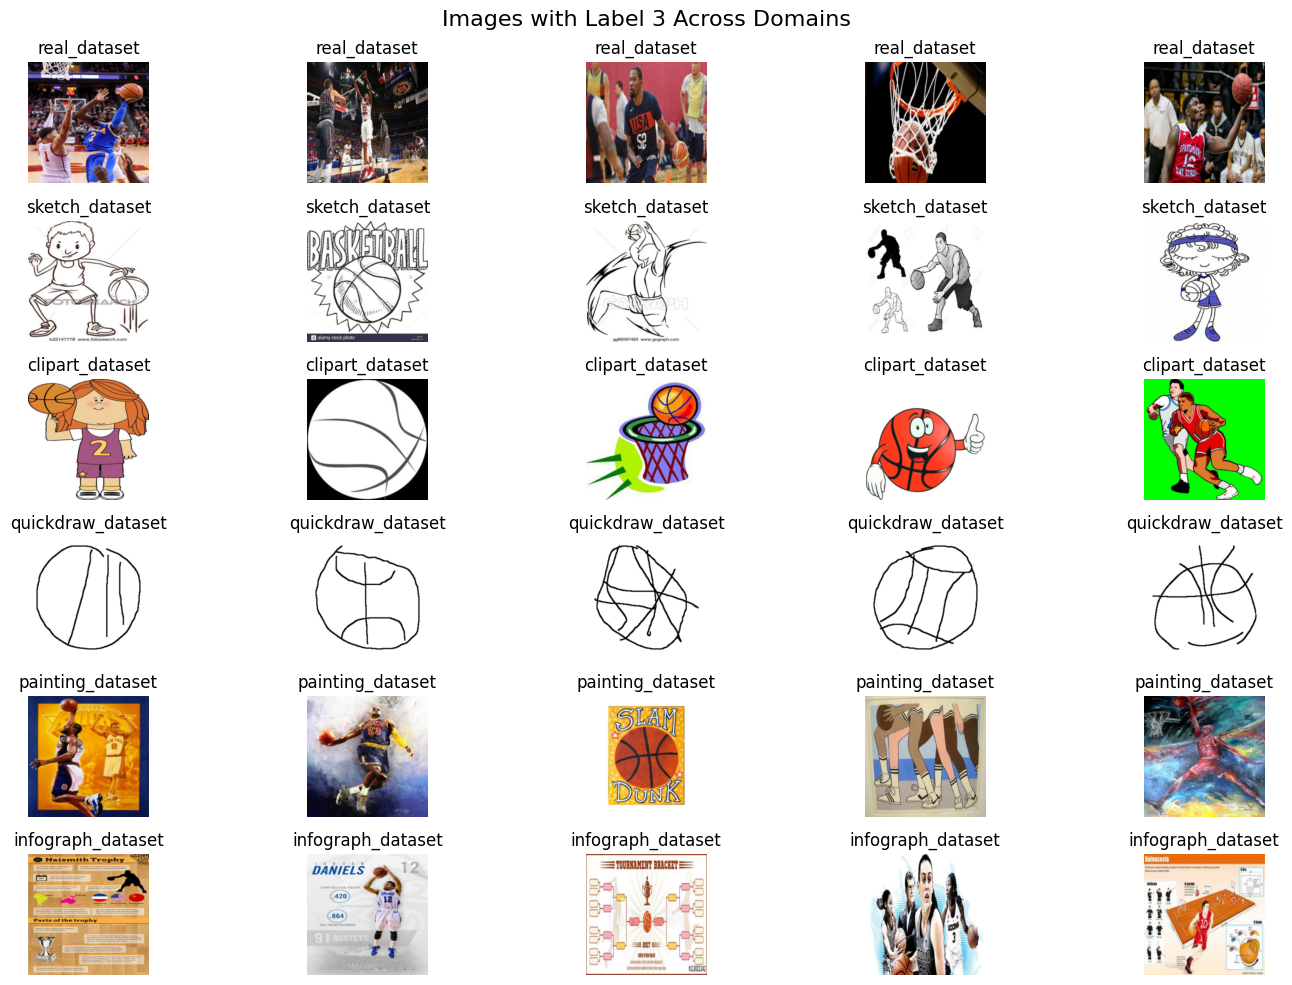

...
...
...
Visualizing Test Loader


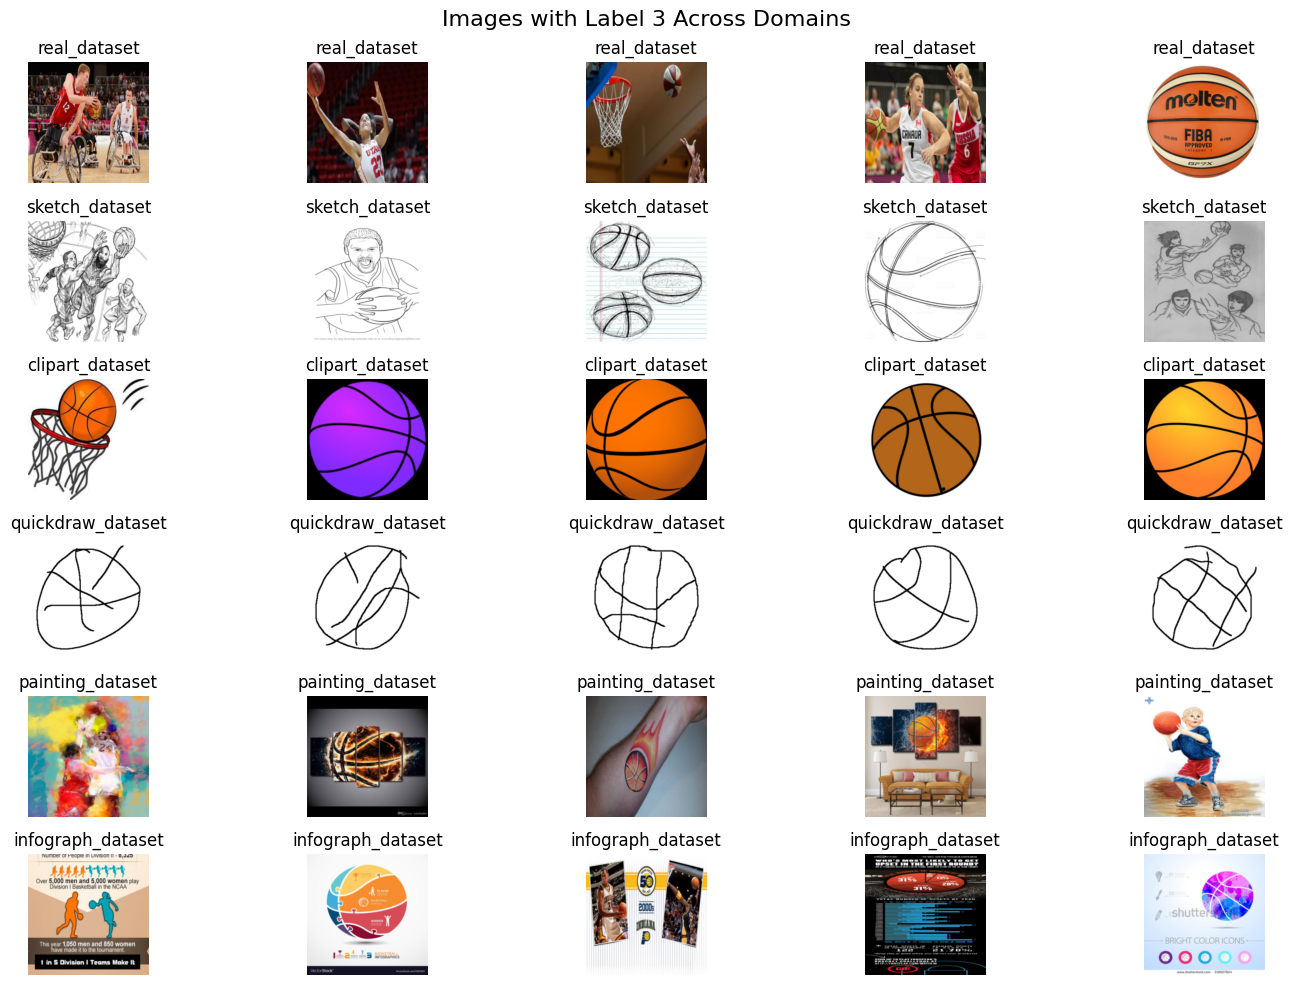

In [19]:
print("Visualizing Train Loader")
# Visualize the images from train loaders
visualize_same_label_across_domains(train_dataloaders, label_to_check=3, num_images_per_domain=5)

print("...")
print("...")
print("...")
print("Visualizing Test Loader")
# Visualize the images from test loaders
visualize_same_label_across_domains(test_dataloaders, label_to_check=3, num_images_per_domain=5)


# **Hyperparameters**

In [37]:
# Hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 10
num_communication_rounds = 20
train_val_split = 0.8  # Percentage of data for training

# Training ratios and class ratios for each dataset
base_training_ratios = {
    'real': 0.35,
    'sketch': 0.35,
    'clipart': 0.35,
    'quickdraw': 0.35,
    'painting': 0.35,
    'infograph': 0.35
}

class_ratios = {
    domain: {i: 0.01 for i in range(20)} for domain in base_training_ratios.keys()
}

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


# **Data Preparation and Dataset Loading**

In [38]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Placeholder paths for datasets
dataset_paths = {
    'real': '/content/doubledataset/domain/real',
    'sketch': '/content/doubledataset/domain/sketch',
    'clipart': '/content/doubledataset/domain/clipart',
    'quickdraw': '/content/doubledataset/domain/quickdraw',
    'painting': '/content/doubledataset/domain/painting',
    'infograph': '/content/doubledataset/domain/infograph'
}

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


def load_custom_dataset(dataset_path, transform=None, max_classes=20):
    images, labels = [], []
    class_to_label = {}
    current_label = 0

    for root, dirs, files in os.walk(dataset_path):
        if files:
            class_name = os.path.basename(root)
            if class_name not in class_to_label:
                if current_label >= max_classes:
                    continue
                class_to_label[class_name] = current_label
                current_label += 1

            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    image_path = os.path.join(root, file)
                    images.append(image_path)
                    labels.append(class_to_label[class_name])

    if not images:
        raise ValueError(f"No valid images found in dataset path: {dataset_path}")

    return CustomDataset(images, labels, transform)

# Load datasets
datasets = {
    domain: load_custom_dataset(dataset_paths[domain], transform, max_classes=20)
    for domain in dataset_paths.keys()
}

# Create test loaders
test_dataloaders = {
    domain: DataLoader(datasets[domain], batch_size=batch_size, shuffle=False)
    for domain in datasets.keys()
}

# **Dataset Sorting and Dynamic Dataset Creation**

In [ ]:
def sort_by_class(dataset, num_classes=20):
    sorted_data = {i: [] for i in range(num_classes)}
    for idx in range(len(dataset)):
        image, label = dataset[idx]
        sorted_data[label].append((image, label))
    return sorted_data

def create_dynamic_dataset(sorted_data, ratio_size, class_ratios, num_classes=20):
    dynamic_dataset = []
    total_size = int(sum(len(v) for v in sorted_data.values()) * ratio_size)
    for class_label in range(num_classes):
        ratio = class_ratios.get(class_label, 1 / num_classes)
        num_samples = min(int(total_size * ratio), len(sorted_data[class_label]))
        sampled_data = random.sample(sorted_data[class_label], num_samples)
        dynamic_dataset.extend(sampled_data)
    return dynamic_dataset

sorted_datasets = {
    domain: sort_by_class(datasets[domain], 20) for domain in datasets.keys()
}

# **Model Definition - SimpleCNN**

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=20):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# **Local Training Function**

In [ ]:
def local_train(model, dataset_name, training_ratios, class_ratios, criterion, optimizer, epochs):
    model.train()

    # Create dataset dynamically based on training ratios and class_ratios
    sorted_data = sorted_datasets[dataset_name]
    dynamic_dataset = create_dynamic_dataset(sorted_datasets[dataset_name], training_ratios[dataset_name], class_ratios[dataset_name])
    dataloader = DataLoader(dynamic_dataset, batch_size=batch_size, shuffle=True)

    dataset_size = len(dataloader.dataset)
    train_size = int(train_val_split * dataset_size)
    val_size = dataset_size - train_size

    train_dataset, val_dataset = random_split(dataloader.dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        for images, labels in tqdm(train_loader, desc=f"{dataset_name} Training Local Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 20
    class_total = [0] * 20

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"{dataset_name} on Validation dataset"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for i in range(len(labels)):
                class_correct[labels[i]] += (predicted[i] == labels[i]).item()
                class_total[labels[i]] += 1

    overall_acc = 100 * correct / total
    class_acc = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(20)]
    return model, overall_acc, class_acc

# **Model Testing Function**

In [ ]:
def test_model(model, dataloader,name):
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 20
    class_total = [0] * 20

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Testing {name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for i in range(len(labels)):
                class_correct[labels[i]] += (predicted[i] == labels[i]).item()
                class_total[labels[i]] += 1

    overall_acc = 100 * correct / total
    class_acc = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(20)]
    return overall_acc, class_acc, class_correct, class_total

# **Fed Class Avg**

In [ ]:
def fed_class_avg(models, accuracies=None):
    global_model = models[0]
    global_dict = global_model.state_dict()

    if accuracies:
        # Make weights directly proportional to accuracies
        weights = torch.tensor([accuracies[name]['overall'] for name in datasets.keys()], dtype=torch.float32)

        # Normalize the weights to sum up to 1
        weights /= weights.sum()
    else:
        # Assign equal weights if no accuracies are provided
        weights = torch.tensor([1.0 / len(models)] * len(models), dtype=torch.float32)

    # Update global model weights based on the proportional weights
    for key in global_dict.keys():
        weighted_sum = torch.zeros_like(global_dict[key])
        for i in range(len(models)):
            weighted_sum += weights[i] * models[i].state_dict()[key].float()
        global_dict[key] = weighted_sum

    # Load the updated weights into the global model
    global_model.load_state_dict(global_dict)
    return global_model


# **Displaying Dataset & Class Accuracies**

In [44]:
def display_accuracy_all(model, loaders, names):
        accuracies = {}
        total_correct = [0] * 20
        total_count = [0] * 20
        print("====================Starting Testing on Test Dataset======================")
        for loader, name in zip(loaders, names):
            overall, class_acc, correct, count = test_model(model, loader,name)
            accuracies[name] = {'overall': overall, 'class_acc': class_acc}
            print(f"{name} Overall Accuracy: {overall:.2f}%")
            for i in range(20):
                total_correct[i] += correct[i]
                total_count[i] += count[i]
                print(f"{name} Accuracy for Class {i}: {class_acc[i]:.2f}%")

        combined_accuracy = sum(total_correct) / sum(total_count) * 100
        print(f"Overall Accuracy Across All Datasets: {combined_accuracy:.2f}%")
        print("====================Ending Testing on Test Dataset======================")
        return accuracies

# **Training Loop with Communication Rounds**

In [45]:
models = [SimpleCNN().to(device) for _ in range(len(datasets))]
criterions = [nn.CrossEntropyLoss() for _ in range(len(datasets))]
optimizers = [torch.optim.Adam(models[i].parameters(), lr=learning_rate) for i in range(len(datasets))]
names = list(datasets.keys())

accuracies = None
test_accuracies = []
training_ratios = base_training_ratios.copy()

for no_communication in range(num_communication_rounds):
    print(f"Communication Round {no_communication+1}/{num_communication_rounds}")

    # Train each model for the specified domain
    models[0], real_overall_acc, real_class_acc = local_train(models[0], 'real', training_ratios, class_ratios, criterions[0], optimizers[0], num_epochs)
    models[1], sketch_overall_acc, sketch_class_acc = local_train(models[1], 'sketch', training_ratios, class_ratios, criterions[1], optimizers[1], num_epochs)
    models[2], clipart_overall_acc, clipart_class_acc = local_train(models[2], 'clipart', training_ratios, class_ratios, criterions[2], optimizers[2], num_epochs)
    models[3], quickdraw_overall_acc, quickdraw_class_acc = local_train(models[3], 'quickdraw', training_ratios, class_ratios, criterions[3], optimizers[3], num_epochs)
    models[4], painting_overall_acc, painting_class_acc = local_train(models[4], 'painting', training_ratios, class_ratios, criterions[4], optimizers[4], num_epochs)
    models[5], infograph_overall_acc, infograph_class_acc = local_train(models[5], 'infograph', training_ratios, class_ratios, criterions[5], optimizers[5], num_epochs)

    accuracies = {}
    accuracies['real'] = {'overall': real_overall_acc, 'class_acc': real_class_acc}
    accuracies['sketch'] = {'overall': sketch_overall_acc, 'class_acc': sketch_class_acc}
    accuracies['clipart'] = {'overall': clipart_overall_acc, 'class_acc': clipart_class_acc}
    accuracies['quickdraw'] = {'overall': quickdraw_overall_acc, 'class_acc': quickdraw_class_acc}
    accuracies['painting'] = {'overall': painting_overall_acc, 'class_acc': painting_class_acc}
    accuracies['infograph'] = {'overall': infograph_overall_acc, 'class_acc': infograph_class_acc}
    print("accuracies =", accuracies)

    global_model = fed_class_avg(models, accuracies)
    loaders = [test_dataloaders[domain] for domain in datasets.keys()]

    test_acc = display_accuracy_all(global_model, loaders, names)
    test_accuracies.append(test_acc)

    for i in range(6):
        models[i].load_state_dict(global_model.state_dict())

    weights = torch.tensor([1 / max(accuracies[name]['overall'], 1e-6) for name in ['real', 'sketch', 'clipart', 'quickdraw', 'painting', 'infograph']], dtype=torch.float32)
    print("Testing Weights 1 (before normalization):", weights)
    weights /= weights.sum()
    print("Testing Weights 2 (after normalization):", weights)

    print("base_training_ratios =", base_training_ratios)
    additional_size = 0.2
    base_ratios = torch.tensor([base_training_ratios['real'], base_training_ratios['sketch'], base_training_ratios['clipart'], base_training_ratios['quickdraw'], base_training_ratios['painting'], base_training_ratios['infograph']], dtype=torch.float32)
    weights = torch.tensor([1 / max(accuracies[name]['overall'], 1e-6) for name in ['real', 'sketch', 'clipart', 'quickdraw', 'painting', 'infograph']], dtype=torch.float32)
    weights /= weights.sum()
    scaled_addition = weights * additional_size
    new_ratios = base_ratios + scaled_addition

    new_training_ratios = {}
    new_training_ratios['real'] = new_ratios[0].item()
    new_training_ratios['sketch'] = new_ratios[1].item()
    new_training_ratios['clipart'] = new_ratios[2].item()
    new_training_ratios['quickdraw'] = new_ratios[3].item()
    new_training_ratios['painting'] = new_ratios[4].item()
    new_training_ratios['infograph'] = new_ratios[5].item()

    print("new_training_ratios:", new_training_ratios)

    base_ratio = 0.3
    for dataset in ['real', 'sketch', 'clipart', 'quickdraw', 'painting', 'infograph']:
        class_acc = accuracies[dataset]['class_acc']
        weights = torch.tensor([1 / acc if acc > 0 else 1.0 for acc in class_acc], dtype=torch.float32)
        weights /= weights.sum()
        dynamic_class_ratios = [base_ratio / 10 + (1 - base_ratio) * w.item() for w in weights]
        class_ratios[dataset] = {i: dynamic_class_ratios[i] for i in range(10)}

    print("Updated Class Ratios:", class_ratios)

Communication Round 1/20


infograph on Validation dataset: 100%|██████████| 1/1 [00:00<00:00, 102.20it/s]


accuracies = {'real': {'overall': 47.22222222222222, 'class_acc': [33.333333333333336, 40.0, 75.0, 50.0, 40.0, 55.55555555555556, 50.0, 100.0, 60.0, 25.0, 50.0, 100.0, 25.0, 66.66666666666667, 57.142857142857146, 37.5, 40.0, 50.0, 25.0, 0.0]}, 'sketch': {'overall': 13.88888888888889, 'class_acc': [100.0, 0.0, 0.0, 20.0, 0.0, 60.0, 0.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 20.0, 0.0, 25.0]}, 'clipart': {'overall': 19.642857142857142, 'class_acc': [0.0, 0.0, 100.0, 16.666666666666668, 0.0, 33.333333333333336, 0.0, 100.0, 50.0, 33.333333333333336, 0.0, 50.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0]}, 'quickdraw': {'overall': 46.42857142857143, 'class_acc': [85.71428571428571, 57.142857142857146, 57.142857142857146, 28.571428571428573, 83.33333333333333, 50.0, 28.571428571428573, 11.11111111111111, 33.333333333333336, 83.33333333333333, 75.0, 33.333333333333336, 85.71428571428571, 60.0, 100.0, 30.76923076923077, 22.22222222222222, 0.0, 66.66666666666667, 0.0]}, 'painting': 

Testing real: 100%|██████████| 62/62 [00:25<00:00,  2.40it/s]


real Overall Accuracy: 7.37%
real Accuracy for Class 0: 0.00%
real Accuracy for Class 1: 0.00%
real Accuracy for Class 2: 0.00%
real Accuracy for Class 3: 31.00%
real Accuracy for Class 4: 0.00%
real Accuracy for Class 5: 0.00%
real Accuracy for Class 6: 0.00%
real Accuracy for Class 7: 0.00%
real Accuracy for Class 8: 0.00%
real Accuracy for Class 9: 0.00%
real Accuracy for Class 10: 0.00%
real Accuracy for Class 11: 0.00%
real Accuracy for Class 12: 0.00%
real Accuracy for Class 13: 0.00%
real Accuracy for Class 14: 1.81%
real Accuracy for Class 15: 0.00%
real Accuracy for Class 16: 0.00%
real Accuracy for Class 17: 96.77%
real Accuracy for Class 18: 0.56%
real Accuracy for Class 19: 0.00%


Testing sketch: 100%|██████████| 41/41 [00:18<00:00,  2.26it/s]


sketch Overall Accuracy: 4.86%
sketch Accuracy for Class 0: 0.00%
sketch Accuracy for Class 1: 0.00%
sketch Accuracy for Class 2: 0.00%
sketch Accuracy for Class 3: 0.74%
sketch Accuracy for Class 4: 0.00%
sketch Accuracy for Class 5: 0.00%
sketch Accuracy for Class 6: 0.00%
sketch Accuracy for Class 7: 0.00%
sketch Accuracy for Class 8: 0.00%
sketch Accuracy for Class 9: 0.00%
sketch Accuracy for Class 10: 0.00%
sketch Accuracy for Class 11: 0.00%
sketch Accuracy for Class 12: 0.00%
sketch Accuracy for Class 13: 0.00%
sketch Accuracy for Class 14: 1.30%
sketch Accuracy for Class 15: 0.00%
sketch Accuracy for Class 16: 0.00%
sketch Accuracy for Class 17: 98.41%
sketch Accuracy for Class 18: 0.00%
sketch Accuracy for Class 19: 0.00%


Testing clipart: 100%|██████████| 33/33 [00:12<00:00,  2.56it/s]


clipart Overall Accuracy: 5.75%
clipart Accuracy for Class 0: 0.00%
clipart Accuracy for Class 1: 0.00%
clipart Accuracy for Class 2: 0.00%
clipart Accuracy for Class 3: 13.41%
clipart Accuracy for Class 4: 0.00%
clipart Accuracy for Class 5: 0.00%
clipart Accuracy for Class 6: 0.00%
clipart Accuracy for Class 7: 0.68%
clipart Accuracy for Class 8: 0.00%
clipart Accuracy for Class 9: 0.00%
clipart Accuracy for Class 10: 0.00%
clipart Accuracy for Class 11: 0.00%
clipart Accuracy for Class 12: 0.00%
clipart Accuracy for Class 13: 0.00%
clipart Accuracy for Class 14: 10.48%
clipart Accuracy for Class 15: 0.00%
clipart Accuracy for Class 16: 0.00%
clipart Accuracy for Class 17: 90.30%
clipart Accuracy for Class 18: 2.77%
clipart Accuracy for Class 19: 0.00%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


quickdraw Overall Accuracy: 5.00%
quickdraw Accuracy for Class 0: 0.00%
quickdraw Accuracy for Class 1: 0.00%
quickdraw Accuracy for Class 2: 0.00%
quickdraw Accuracy for Class 3: 0.00%
quickdraw Accuracy for Class 4: 0.00%
quickdraw Accuracy for Class 5: 0.00%
quickdraw Accuracy for Class 6: 0.00%
quickdraw Accuracy for Class 7: 0.00%
quickdraw Accuracy for Class 8: 0.00%
quickdraw Accuracy for Class 9: 0.00%
quickdraw Accuracy for Class 10: 0.00%
quickdraw Accuracy for Class 11: 0.00%
quickdraw Accuracy for Class 12: 0.00%
quickdraw Accuracy for Class 13: 0.00%
quickdraw Accuracy for Class 14: 0.00%
quickdraw Accuracy for Class 15: 0.00%
quickdraw Accuracy for Class 16: 0.00%
quickdraw Accuracy for Class 17: 100.00%
quickdraw Accuracy for Class 18: 0.00%
quickdraw Accuracy for Class 19: 0.00%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


painting Overall Accuracy: 3.47%
painting Accuracy for Class 0: 0.00%
painting Accuracy for Class 1: 0.00%
painting Accuracy for Class 2: 0.00%
painting Accuracy for Class 3: 14.85%
painting Accuracy for Class 4: 0.00%
painting Accuracy for Class 5: 0.00%
painting Accuracy for Class 6: 0.00%
painting Accuracy for Class 7: 0.00%
painting Accuracy for Class 8: 0.00%
painting Accuracy for Class 9: 0.00%
painting Accuracy for Class 10: 0.00%
painting Accuracy for Class 11: 0.00%
painting Accuracy for Class 12: 0.00%
painting Accuracy for Class 13: 0.00%
painting Accuracy for Class 14: 2.61%
painting Accuracy for Class 15: 0.00%
painting Accuracy for Class 16: 0.00%
painting Accuracy for Class 17: 95.03%
painting Accuracy for Class 18: 0.62%
painting Accuracy for Class 19: 0.00%


Testing infograph: 100%|██████████| 42/42 [00:31<00:00,  1.34it/s]


infograph Overall Accuracy: 9.50%
infograph Accuracy for Class 0: 0.00%
infograph Accuracy for Class 1: 0.00%
infograph Accuracy for Class 2: 0.00%
infograph Accuracy for Class 3: 18.06%
infograph Accuracy for Class 4: 0.00%
infograph Accuracy for Class 5: 0.00%
infograph Accuracy for Class 6: 0.00%
infograph Accuracy for Class 7: 0.64%
infograph Accuracy for Class 8: 0.00%
infograph Accuracy for Class 9: 0.00%
infograph Accuracy for Class 10: 0.00%
infograph Accuracy for Class 11: 0.00%
infograph Accuracy for Class 12: 0.00%
infograph Accuracy for Class 13: 0.00%
infograph Accuracy for Class 14: 1.75%
infograph Accuracy for Class 15: 0.00%
infograph Accuracy for Class 16: 0.00%
infograph Accuracy for Class 17: 94.18%
infograph Accuracy for Class 18: 0.00%
infograph Accuracy for Class 19: 0.00%
Overall Accuracy Across All Datasets: 5.91%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0212, 0.0720, 0.0509, 0.0

infograph on Validation dataset: 100%|██████████| 4/4 [00:00<00:00, 84.72it/s]


accuracies = {'real': {'overall': 51.30784708249497, 'class_acc': [30.434782608695652, 22.22222222222222, 40.0, 63.63636363636363, 19.047619047619047, 46.42857142857143, 84.61538461538461, 100.0, 42.857142857142854, 48.148148148148145, 51.851851851851855, 70.96774193548387, 31.57894736842105, 82.75862068965517, 44.0, 25.806451612903224, 51.61290322580645, 74.19354838709677, 56.666666666666664, 55.55555555555556]}, 'sketch': {'overall': 18.796992481203006, 'class_acc': [0.0, 7.6923076923076925, 36.111111111111114, 0.0, 4.444444444444445, 52.94117647058823, 9.523809523809524, 0.0, 50.0, 54.54545454545455, 7.142857142857143, 36.36363636363637, 5.2631578947368425, 15.789473684210526, 18.75, 11.11111111111111, 29.41176470588235, 9.090909090909092, 0.0, 5.0]}, 'clipart': {'overall': 35.810810810810814, 'class_acc': [58.333333333333336, 22.580645161290324, 10.0, 8.333333333333334, 77.77777777777777, 60.0, 61.53846153846154, 85.71428571428571, 12.5, 37.5, 50.0, 41.666666666666664, 4.7619047619

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.38it/s]


real Overall Accuracy: 17.62%
real Accuracy for Class 0: 2.13%
real Accuracy for Class 1: 11.97%
real Accuracy for Class 2: 15.49%
real Accuracy for Class 3: 0.89%
real Accuracy for Class 4: 49.90%
real Accuracy for Class 5: 99.31%
real Accuracy for Class 6: 28.70%
real Accuracy for Class 7: 9.52%
real Accuracy for Class 8: 0.00%
real Accuracy for Class 9: 9.65%
real Accuracy for Class 10: 11.60%
real Accuracy for Class 11: 31.19%
real Accuracy for Class 12: 0.23%
real Accuracy for Class 13: 21.41%
real Accuracy for Class 14: 7.58%
real Accuracy for Class 15: 10.13%
real Accuracy for Class 16: 8.19%
real Accuracy for Class 17: 13.21%
real Accuracy for Class 18: 3.89%
real Accuracy for Class 19: 48.53%


Testing sketch: 100%|██████████| 41/41 [00:19<00:00,  2.10it/s]


sketch Overall Accuracy: 10.41%
sketch Accuracy for Class 0: 0.28%
sketch Accuracy for Class 1: 10.23%
sketch Accuracy for Class 2: 2.58%
sketch Accuracy for Class 3: 0.00%
sketch Accuracy for Class 4: 77.08%
sketch Accuracy for Class 5: 57.93%
sketch Accuracy for Class 6: 1.00%
sketch Accuracy for Class 7: 0.00%
sketch Accuracy for Class 8: 0.00%
sketch Accuracy for Class 9: 0.99%
sketch Accuracy for Class 10: 13.13%
sketch Accuracy for Class 11: 6.16%
sketch Accuracy for Class 12: 0.32%
sketch Accuracy for Class 13: 9.45%
sketch Accuracy for Class 14: 2.59%
sketch Accuracy for Class 15: 7.58%
sketch Accuracy for Class 16: 5.56%
sketch Accuracy for Class 17: 4.38%
sketch Accuracy for Class 18: 0.30%
sketch Accuracy for Class 19: 9.81%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.52it/s]


clipart Overall Accuracy: 15.51%
clipart Accuracy for Class 0: 3.70%
clipart Accuracy for Class 1: 14.21%
clipart Accuracy for Class 2: 6.15%
clipart Accuracy for Class 3: 1.17%
clipart Accuracy for Class 4: 60.07%
clipart Accuracy for Class 5: 68.00%
clipart Accuracy for Class 6: 14.53%
clipart Accuracy for Class 7: 8.78%
clipart Accuracy for Class 8: 0.00%
clipart Accuracy for Class 9: 20.10%
clipart Accuracy for Class 10: 28.97%
clipart Accuracy for Class 11: 14.79%
clipart Accuracy for Class 12: 0.80%
clipart Accuracy for Class 13: 22.29%
clipart Accuracy for Class 14: 3.81%
clipart Accuracy for Class 15: 14.01%
clipart Accuracy for Class 16: 17.82%
clipart Accuracy for Class 17: 6.06%
clipart Accuracy for Class 18: 1.58%
clipart Accuracy for Class 19: 36.47%


Testing quickdraw: 100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


quickdraw Overall Accuracy: 18.34%
quickdraw Accuracy for Class 0: 0.20%
quickdraw Accuracy for Class 1: 66.00%
quickdraw Accuracy for Class 2: 0.00%
quickdraw Accuracy for Class 3: 0.00%
quickdraw Accuracy for Class 4: 96.60%
quickdraw Accuracy for Class 5: 0.00%
quickdraw Accuracy for Class 6: 0.00%
quickdraw Accuracy for Class 7: 0.00%
quickdraw Accuracy for Class 8: 0.00%
quickdraw Accuracy for Class 9: 89.80%
quickdraw Accuracy for Class 10: 84.80%
quickdraw Accuracy for Class 11: 0.20%
quickdraw Accuracy for Class 12: 0.40%
quickdraw Accuracy for Class 13: 0.20%
quickdraw Accuracy for Class 14: 0.00%
quickdraw Accuracy for Class 15: 21.20%
quickdraw Accuracy for Class 16: 3.20%
quickdraw Accuracy for Class 17: 0.80%
quickdraw Accuracy for Class 18: 0.40%
quickdraw Accuracy for Class 19: 3.00%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


painting Overall Accuracy: 10.75%
painting Accuracy for Class 0: 0.00%
painting Accuracy for Class 1: 1.34%
painting Accuracy for Class 2: 5.59%
painting Accuracy for Class 3: 0.56%
painting Accuracy for Class 4: 41.28%
painting Accuracy for Class 5: 99.48%
painting Accuracy for Class 6: 16.55%
painting Accuracy for Class 7: 3.92%
painting Accuracy for Class 8: 0.00%
painting Accuracy for Class 9: 2.05%
painting Accuracy for Class 10: 0.67%
painting Accuracy for Class 11: 27.61%
painting Accuracy for Class 12: 0.00%
painting Accuracy for Class 13: 12.91%
painting Accuracy for Class 14: 1.90%
painting Accuracy for Class 15: 10.19%
painting Accuracy for Class 16: 3.51%
painting Accuracy for Class 17: 1.24%
painting Accuracy for Class 18: 0.82%
painting Accuracy for Class 19: 10.82%


Testing infograph: 100%|██████████| 42/42 [00:33<00:00,  1.27it/s]


infograph Overall Accuracy: 8.95%
infograph Accuracy for Class 0: 1.68%
infograph Accuracy for Class 1: 8.79%
infograph Accuracy for Class 2: 11.32%
infograph Accuracy for Class 3: 2.55%
infograph Accuracy for Class 4: 41.20%
infograph Accuracy for Class 5: 83.04%
infograph Accuracy for Class 6: 19.01%
infograph Accuracy for Class 7: 2.56%
infograph Accuracy for Class 8: 0.00%
infograph Accuracy for Class 9: 0.81%
infograph Accuracy for Class 10: 3.72%
infograph Accuracy for Class 11: 6.08%
infograph Accuracy for Class 12: 0.45%
infograph Accuracy for Class 13: 14.00%
infograph Accuracy for Class 14: 2.81%
infograph Accuracy for Class 15: 8.12%
infograph Accuracy for Class 16: 1.29%
infograph Accuracy for Class 17: 1.34%
infograph Accuracy for Class 18: 0.00%
infograph Accuracy for Class 19: 1.84%
Overall Accuracy Across All Datasets: 14.30%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0195, 0.0532, 0.0279,

infograph on Validation dataset: 100%|██████████| 3/3 [00:00<00:00, 78.94it/s]


accuracies = {'real': {'overall': 56.441717791411044, 'class_acc': [41.46341463414634, 65.0, 73.91304347826087, 48.275862068965516, 30.508474576271187, 71.875, 51.724137931034484, 96.875, 51.42857142857143, 51.61290322580645, 54.166666666666664, 88.23529411764706, 35.483870967741936, 76.19047619047619, 58.62068965517241, 60.714285714285715, 42.857142857142854, 42.857142857142854, 65.625, 45.0]}, 'sketch': {'overall': 26.91415313225058, 'class_acc': [40.38461538461539, 6.25, 40.0, 26.923076923076923, 44.0, 62.5, 20.0, 14.893617021276595, 0.0, 20.0, 10.0, 20.0, 11.11111111111111, 13.333333333333334, 33.333333333333336, 35.0, 60.0, 14.285714285714286, 11.11111111111111, 55.55555555555556]}, 'clipart': {'overall': 36.329588014981276, 'class_acc': [25.0, 45.45454545454545, 47.05882352941177, 33.333333333333336, 18.181818181818183, 27.272727272727273, 14.285714285714286, 28.571428571428573, 42.857142857142854, 66.66666666666667, 50.0, 52.94117647058823, 7.142857142857143, 60.0, 23.5294117647

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.38it/s]


real Overall Accuracy: 41.72%
real Accuracy for Class 0: 33.65%
real Accuracy for Class 1: 32.71%
real Accuracy for Class 2: 58.45%
real Accuracy for Class 3: 41.58%
real Accuracy for Class 4: 18.22%
real Accuracy for Class 5: 6.92%
real Accuracy for Class 6: 49.38%
real Accuracy for Class 7: 96.03%
real Accuracy for Class 8: 5.91%
real Accuracy for Class 9: 33.59%
real Accuracy for Class 10: 27.35%
real Accuracy for Class 11: 49.30%
real Accuracy for Class 12: 7.64%
real Accuracy for Class 13: 53.35%
real Accuracy for Class 14: 86.00%
real Accuracy for Class 15: 66.96%
real Accuracy for Class 16: 56.86%
real Accuracy for Class 17: 20.75%
real Accuracy for Class 18: 3.61%
real Accuracy for Class 19: 43.38%


Testing sketch: 100%|██████████| 41/41 [00:18<00:00,  2.20it/s]


sketch Overall Accuracy: 15.68%
sketch Accuracy for Class 0: 21.88%
sketch Accuracy for Class 1: 30.03%
sketch Accuracy for Class 2: 6.44%
sketch Accuracy for Class 3: 4.41%
sketch Accuracy for Class 4: 30.36%
sketch Accuracy for Class 5: 5.52%
sketch Accuracy for Class 6: 2.00%
sketch Accuracy for Class 7: 34.68%
sketch Accuracy for Class 8: 0.00%
sketch Accuracy for Class 9: 15.84%
sketch Accuracy for Class 10: 13.47%
sketch Accuracy for Class 11: 12.32%
sketch Accuracy for Class 12: 1.62%
sketch Accuracy for Class 13: 4.48%
sketch Accuracy for Class 14: 38.08%
sketch Accuracy for Class 15: 15.15%
sketch Accuracy for Class 16: 45.83%
sketch Accuracy for Class 17: 10.76%
sketch Accuracy for Class 18: 5.36%
sketch Accuracy for Class 19: 9.55%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.49it/s]


clipart Overall Accuracy: 28.96%
clipart Accuracy for Class 0: 33.33%
clipart Accuracy for Class 1: 22.40%
clipart Accuracy for Class 2: 24.62%
clipart Accuracy for Class 3: 22.45%
clipart Accuracy for Class 4: 13.81%
clipart Accuracy for Class 5: 10.00%
clipart Accuracy for Class 6: 21.51%
clipart Accuracy for Class 7: 72.30%
clipart Accuracy for Class 8: 6.56%
clipart Accuracy for Class 9: 45.73%
clipart Accuracy for Class 10: 42.76%
clipart Accuracy for Class 11: 18.93%
clipart Accuracy for Class 12: 2.92%
clipart Accuracy for Class 13: 23.57%
clipart Accuracy for Class 14: 39.05%
clipart Accuracy for Class 15: 51.82%
clipart Accuracy for Class 16: 74.75%
clipart Accuracy for Class 17: 14.55%
clipart Accuracy for Class 18: 5.14%
clipart Accuracy for Class 19: 47.06%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.89it/s]


quickdraw Overall Accuracy: 36.85%
quickdraw Accuracy for Class 0: 82.40%
quickdraw Accuracy for Class 1: 89.20%
quickdraw Accuracy for Class 2: 5.20%
quickdraw Accuracy for Class 3: 3.60%
quickdraw Accuracy for Class 4: 59.00%
quickdraw Accuracy for Class 5: 0.00%
quickdraw Accuracy for Class 6: 1.80%
quickdraw Accuracy for Class 7: 54.00%
quickdraw Accuracy for Class 8: 0.00%
quickdraw Accuracy for Class 9: 99.80%
quickdraw Accuracy for Class 10: 78.80%
quickdraw Accuracy for Class 11: 1.80%
quickdraw Accuracy for Class 12: 9.20%
quickdraw Accuracy for Class 13: 20.80%
quickdraw Accuracy for Class 14: 10.20%
quickdraw Accuracy for Class 15: 20.00%
quickdraw Accuracy for Class 16: 76.80%
quickdraw Accuracy for Class 17: 29.20%
quickdraw Accuracy for Class 18: 46.40%
quickdraw Accuracy for Class 19: 48.80%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


painting Overall Accuracy: 25.26%
painting Accuracy for Class 0: 23.91%
painting Accuracy for Class 1: 2.01%
painting Accuracy for Class 2: 15.64%
painting Accuracy for Class 3: 23.25%
painting Accuracy for Class 4: 14.53%
painting Accuracy for Class 5: 6.81%
painting Accuracy for Class 6: 23.74%
painting Accuracy for Class 7: 64.16%
painting Accuracy for Class 8: 1.09%
painting Accuracy for Class 9: 7.53%
painting Accuracy for Class 10: 0.67%
painting Accuracy for Class 11: 37.80%
painting Accuracy for Class 12: 2.67%
painting Accuracy for Class 13: 29.11%
painting Accuracy for Class 14: 71.80%
painting Accuracy for Class 15: 48.30%
painting Accuracy for Class 16: 34.50%
painting Accuracy for Class 17: 6.83%
painting Accuracy for Class 18: 2.06%
painting Accuracy for Class 19: 29.48%


Testing infograph: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s]


infograph Overall Accuracy: 16.59%
infograph Accuracy for Class 0: 14.29%
infograph Accuracy for Class 1: 13.74%
infograph Accuracy for Class 2: 12.58%
infograph Accuracy for Class 3: 27.08%
infograph Accuracy for Class 4: 6.25%
infograph Accuracy for Class 5: 2.68%
infograph Accuracy for Class 6: 38.03%
infograph Accuracy for Class 7: 61.54%
infograph Accuracy for Class 8: 0.46%
infograph Accuracy for Class 9: 4.03%
infograph Accuracy for Class 10: 7.83%
infograph Accuracy for Class 11: 14.89%
infograph Accuracy for Class 12: 1.34%
infograph Accuracy for Class 13: 9.33%
infograph Accuracy for Class 14: 31.23%
infograph Accuracy for Class 15: 27.27%
infograph Accuracy for Class 16: 27.47%
infograph Accuracy for Class 17: 7.16%
infograph Accuracy for Class 18: 4.29%
infograph Accuracy for Class 19: 7.36%
Overall Accuracy Across All Datasets: 29.49%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0177, 0.0372, 0

infograph on Validation dataset: 100%|██████████| 4/4 [00:00<00:00, 63.83it/s]


accuracies = {'real': {'overall': 59.58795562599049, 'class_acc': [44.44444444444444, 60.0, 67.56756756756756, 47.36842105263158, 66.66666666666667, 66.66666666666667, 58.8235294117647, 86.48648648648648, 60.97560975609756, 72.72727272727273, 35.0, 76.66666666666667, 35.483870967741936, 72.41379310344827, 68.18181818181819, 40.0, 70.0, 35.714285714285715, 53.84615384615385, 56.0]}, 'sketch': {'overall': 29.18918918918919, 'class_acc': [31.57894736842105, 10.0, 44.44444444444444, 50.0, 7.6923076923076925, 40.0, 23.529411764705884, 21.05263157894737, 23.076923076923077, 36.8421052631579, 6.25, 45.833333333333336, 26.08695652173913, 35.0, 53.333333333333336, 44.44444444444444, 26.666666666666668, 20.0, 11.764705882352942, 53.84615384615385]}, 'clipart': {'overall': 45.283018867924525, 'class_acc': [57.89473684210526, 47.05882352941177, 33.333333333333336, 27.272727272727273, 24.0, 72.72727272727273, 69.23076923076923, 76.47058823529412, 37.5, 30.76923076923077, 57.142857142857146, 66.6666

Testing real: 100%|██████████| 62/62 [00:25<00:00,  2.39it/s]


real Overall Accuracy: 40.79%
real Accuracy for Class 0: 32.70%
real Accuracy for Class 1: 27.13%
real Accuracy for Class 2: 48.94%
real Accuracy for Class 3: 18.33%
real Accuracy for Class 4: 36.04%
real Accuracy for Class 5: 82.01%
real Accuracy for Class 6: 67.90%
real Accuracy for Class 7: 79.63%
real Accuracy for Class 8: 2.95%
real Accuracy for Class 9: 20.85%
real Accuracy for Class 10: 29.83%
real Accuracy for Class 11: 83.30%
real Accuracy for Class 12: 4.86%
real Accuracy for Class 13: 51.12%
real Accuracy for Class 14: 54.53%
real Accuracy for Class 15: 42.95%
real Accuracy for Class 16: 27.21%
real Accuracy for Class 17: 31.54%
real Accuracy for Class 18: 5.83%
real Accuracy for Class 19: 79.04%


Testing sketch: 100%|██████████| 41/41 [00:18<00:00,  2.23it/s]


sketch Overall Accuracy: 19.01%
sketch Accuracy for Class 0: 13.02%
sketch Accuracy for Class 1: 13.86%
sketch Accuracy for Class 2: 27.25%
sketch Accuracy for Class 3: 2.57%
sketch Accuracy for Class 4: 44.94%
sketch Accuracy for Class 5: 66.90%
sketch Accuracy for Class 6: 12.00%
sketch Accuracy for Class 7: 0.58%
sketch Accuracy for Class 8: 1.25%
sketch Accuracy for Class 9: 4.95%
sketch Accuracy for Class 10: 18.18%
sketch Accuracy for Class 11: 24.17%
sketch Accuracy for Class 12: 3.88%
sketch Accuracy for Class 13: 11.94%
sketch Accuracy for Class 14: 17.36%
sketch Accuracy for Class 15: 10.61%
sketch Accuracy for Class 16: 25.69%
sketch Accuracy for Class 17: 21.51%
sketch Accuracy for Class 18: 10.42%
sketch Accuracy for Class 19: 37.93%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.50it/s]


clipart Overall Accuracy: 29.59%
clipart Accuracy for Class 0: 17.90%
clipart Accuracy for Class 1: 25.68%
clipart Accuracy for Class 2: 28.21%
clipart Accuracy for Class 3: 12.54%
clipart Accuracy for Class 4: 32.09%
clipart Accuracy for Class 5: 72.00%
clipart Accuracy for Class 6: 33.14%
clipart Accuracy for Class 7: 37.16%
clipart Accuracy for Class 8: 22.95%
clipart Accuracy for Class 9: 24.12%
clipart Accuracy for Class 10: 46.90%
clipart Accuracy for Class 11: 53.25%
clipart Accuracy for Class 12: 6.10%
clipart Accuracy for Class 13: 37.58%
clipart Accuracy for Class 14: 30.48%
clipart Accuracy for Class 15: 36.97%
clipart Accuracy for Class 16: 37.13%
clipart Accuracy for Class 17: 23.64%
clipart Accuracy for Class 18: 10.28%
clipart Accuracy for Class 19: 76.47%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


quickdraw Overall Accuracy: 52.39%
quickdraw Accuracy for Class 0: 69.40%
quickdraw Accuracy for Class 1: 90.80%
quickdraw Accuracy for Class 2: 50.00%
quickdraw Accuracy for Class 3: 5.20%
quickdraw Accuracy for Class 4: 76.00%
quickdraw Accuracy for Class 5: 76.40%
quickdraw Accuracy for Class 6: 38.00%
quickdraw Accuracy for Class 7: 0.00%
quickdraw Accuracy for Class 8: 10.20%
quickdraw Accuracy for Class 9: 99.00%
quickdraw Accuracy for Class 10: 86.40%
quickdraw Accuracy for Class 11: 22.00%
quickdraw Accuracy for Class 12: 85.80%
quickdraw Accuracy for Class 13: 60.20%
quickdraw Accuracy for Class 14: 16.40%
quickdraw Accuracy for Class 15: 31.20%
quickdraw Accuracy for Class 16: 34.00%
quickdraw Accuracy for Class 17: 41.00%
quickdraw Accuracy for Class 18: 61.60%
quickdraw Accuracy for Class 19: 94.20%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


painting Overall Accuracy: 22.88%
painting Accuracy for Class 0: 16.15%
painting Accuracy for Class 1: 2.01%
painting Accuracy for Class 2: 13.97%
painting Accuracy for Class 3: 10.36%
painting Accuracy for Class 4: 22.38%
painting Accuracy for Class 5: 87.96%
painting Accuracy for Class 6: 34.53%
painting Accuracy for Class 7: 18.98%
painting Accuracy for Class 8: 1.81%
painting Accuracy for Class 9: 3.08%
painting Accuracy for Class 10: 1.00%
painting Accuracy for Class 11: 61.66%
painting Accuracy for Class 12: 0.53%
painting Accuracy for Class 13: 26.29%
painting Accuracy for Class 14: 40.28%
painting Accuracy for Class 15: 30.19%
painting Accuracy for Class 16: 18.21%
painting Accuracy for Class 17: 10.56%
painting Accuracy for Class 18: 2.89%
painting Accuracy for Class 19: 54.85%


Testing infograph: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]


infograph Overall Accuracy: 14.88%
infograph Accuracy for Class 0: 5.88%
infograph Accuracy for Class 1: 7.42%
infograph Accuracy for Class 2: 16.35%
infograph Accuracy for Class 3: 8.33%
infograph Accuracy for Class 4: 13.19%
infograph Accuracy for Class 5: 75.89%
infograph Accuracy for Class 6: 53.52%
infograph Accuracy for Class 7: 17.95%
infograph Accuracy for Class 8: 0.46%
infograph Accuracy for Class 9: 1.61%
infograph Accuracy for Class 10: 11.74%
infograph Accuracy for Class 11: 24.92%
infograph Accuracy for Class 12: 1.34%
infograph Accuracy for Class 13: 17.33%
infograph Accuracy for Class 14: 25.26%
infograph Accuracy for Class 15: 16.23%
infograph Accuracy for Class 16: 10.73%
infograph Accuracy for Class 17: 13.87%
infograph Accuracy for Class 18: 2.86%
infograph Accuracy for Class 19: 20.86%
Overall Accuracy Across All Datasets: 33.19%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0168, 0.0343

infograph on Validation dataset: 100%|██████████| 3/3 [00:00<00:00, 72.69it/s]


accuracies = {'real': {'overall': 60.229132569558104, 'class_acc': [64.28571428571429, 55.88235294117647, 66.66666666666667, 71.15384615384616, 48.648648648648646, 62.96296296296296, 55.88235294117647, 80.0, 40.476190476190474, 66.66666666666667, 56.52173913043478, 78.78787878787878, 24.137931034482758, 65.38461538461539, 44.44444444444444, 68.57142857142857, 64.70588235294117, 56.52173913043478, 68.0, 67.85714285714286]}, 'sketch': {'overall': 30.861244019138756, 'class_acc': [25.0, 42.857142857142854, 33.333333333333336, 16.666666666666668, 57.5, 58.8235294117647, 35.294117647058826, 19.35483870967742, 22.727272727272727, 52.0, 32.0, 16.666666666666668, 8.695652173913043, 11.764705882352942, 20.0, 26.08695652173913, 23.80952380952381, 30.76923076923077, 11.538461538461538, 35.294117647058826]}, 'clipart': {'overall': 41.666666666666664, 'class_acc': [25.0, 37.5, 46.666666666666664, 38.70967741935484, 39.130434782608695, 63.63636363636363, 42.10526315789474, 61.53846153846154, 37.5, 6

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.38it/s]


real Overall Accuracy: 51.79%
real Accuracy for Class 0: 58.53%
real Accuracy for Class 1: 44.15%
real Accuracy for Class 2: 59.86%
real Accuracy for Class 3: 43.07%
real Accuracy for Class 4: 43.76%
real Accuracy for Class 5: 79.58%
real Accuracy for Class 6: 64.51%
real Accuracy for Class 7: 96.83%
real Accuracy for Class 8: 61.60%
real Accuracy for Class 9: 50.58%
real Accuracy for Class 10: 26.52%
real Accuracy for Class 11: 81.29%
real Accuracy for Class 12: 26.62%
real Accuracy for Class 13: 57.83%
real Accuracy for Class 14: 48.11%
real Accuracy for Class 15: 60.13%
real Accuracy for Class 16: 53.98%
real Accuracy for Class 17: 21.02%
real Accuracy for Class 18: 10.00%
real Accuracy for Class 19: 65.81%


Testing sketch: 100%|██████████| 41/41 [00:19<00:00,  2.13it/s]


sketch Overall Accuracy: 22.63%
sketch Accuracy for Class 0: 32.69%
sketch Accuracy for Class 1: 27.39%
sketch Accuracy for Class 2: 14.81%
sketch Accuracy for Class 3: 12.50%
sketch Accuracy for Class 4: 52.38%
sketch Accuracy for Class 5: 41.38%
sketch Accuracy for Class 6: 26.00%
sketch Accuracy for Class 7: 6.94%
sketch Accuracy for Class 8: 6.25%
sketch Accuracy for Class 9: 28.22%
sketch Accuracy for Class 10: 13.47%
sketch Accuracy for Class 11: 34.60%
sketch Accuracy for Class 12: 7.44%
sketch Accuracy for Class 13: 12.44%
sketch Accuracy for Class 14: 25.13%
sketch Accuracy for Class 15: 22.22%
sketch Accuracy for Class 16: 43.06%
sketch Accuracy for Class 17: 6.37%
sketch Accuracy for Class 18: 10.42%
sketch Accuracy for Class 19: 32.63%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.51it/s]


clipart Overall Accuracy: 36.51%
clipart Accuracy for Class 0: 40.12%
clipart Accuracy for Class 1: 32.79%
clipart Accuracy for Class 2: 29.23%
clipart Accuracy for Class 3: 21.28%
clipart Accuracy for Class 4: 37.69%
clipart Accuracy for Class 5: 50.67%
clipart Accuracy for Class 6: 40.70%
clipart Accuracy for Class 7: 62.16%
clipart Accuracy for Class 8: 50.82%
clipart Accuracy for Class 9: 46.23%
clipart Accuracy for Class 10: 39.31%
clipart Accuracy for Class 11: 55.62%
clipart Accuracy for Class 12: 14.59%
clipart Accuracy for Class 13: 28.66%
clipart Accuracy for Class 14: 33.33%
clipart Accuracy for Class 15: 52.10%
clipart Accuracy for Class 16: 54.95%
clipart Accuracy for Class 17: 13.33%
clipart Accuracy for Class 18: 17.39%
clipart Accuracy for Class 19: 74.12%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


quickdraw Overall Accuracy: 51.46%
quickdraw Accuracy for Class 0: 91.20%
quickdraw Accuracy for Class 1: 93.40%
quickdraw Accuracy for Class 2: 31.20%
quickdraw Accuracy for Class 3: 15.40%
quickdraw Accuracy for Class 4: 74.80%
quickdraw Accuracy for Class 5: 20.00%
quickdraw Accuracy for Class 6: 48.80%
quickdraw Accuracy for Class 7: 13.20%
quickdraw Accuracy for Class 8: 30.40%
quickdraw Accuracy for Class 9: 100.00%
quickdraw Accuracy for Class 10: 77.20%
quickdraw Accuracy for Class 11: 40.60%
quickdraw Accuracy for Class 12: 60.00%
quickdraw Accuracy for Class 13: 49.20%
quickdraw Accuracy for Class 14: 28.60%
quickdraw Accuracy for Class 15: 41.60%
quickdraw Accuracy for Class 16: 59.20%
quickdraw Accuracy for Class 17: 18.80%
quickdraw Accuracy for Class 18: 68.40%
quickdraw Accuracy for Class 19: 67.20%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


painting Overall Accuracy: 30.55%
painting Accuracy for Class 0: 35.71%
painting Accuracy for Class 1: 8.39%
painting Accuracy for Class 2: 19.55%
painting Accuracy for Class 3: 22.97%
painting Accuracy for Class 4: 26.74%
painting Accuracy for Class 5: 85.86%
painting Accuracy for Class 6: 33.45%
painting Accuracy for Class 7: 54.82%
painting Accuracy for Class 8: 21.01%
painting Accuracy for Class 9: 8.90%
painting Accuracy for Class 10: 2.01%
painting Accuracy for Class 11: 76.14%
painting Accuracy for Class 12: 15.51%
painting Accuracy for Class 13: 27.46%
painting Accuracy for Class 14: 37.44%
painting Accuracy for Class 15: 46.04%
painting Accuracy for Class 16: 31.63%
painting Accuracy for Class 17: 2.48%
painting Accuracy for Class 18: 4.12%
painting Accuracy for Class 19: 38.06%


Testing infograph: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s]


infograph Overall Accuracy: 18.92%
infograph Accuracy for Class 0: 22.69%
infograph Accuracy for Class 1: 17.86%
infograph Accuracy for Class 2: 19.50%
infograph Accuracy for Class 3: 23.38%
infograph Accuracy for Class 4: 13.19%
infograph Accuracy for Class 5: 55.36%
infograph Accuracy for Class 6: 52.11%
infograph Accuracy for Class 7: 43.91%
infograph Accuracy for Class 8: 17.35%
infograph Accuracy for Class 9: 7.66%
infograph Accuracy for Class 10: 6.26%
infograph Accuracy for Class 11: 37.69%
infograph Accuracy for Class 12: 8.48%
infograph Accuracy for Class 13: 14.67%
infograph Accuracy for Class 14: 16.84%
infograph Accuracy for Class 15: 22.08%
infograph Accuracy for Class 16: 19.74%
infograph Accuracy for Class 17: 1.79%
infograph Accuracy for Class 18: 6.43%
infograph Accuracy for Class 19: 12.88%
Overall Accuracy Across All Datasets: 38.20%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0166, 0.03

infograph on Validation dataset: 100%|██████████| 4/4 [00:00<00:00, 81.15it/s]


accuracies = {'real': {'overall': 66.02254428341385, 'class_acc': [61.29032258064516, 51.515151515151516, 76.47058823529412, 70.58823529411765, 61.702127659574465, 83.33333333333333, 67.56756756756756, 94.11764705882354, 62.7906976744186, 70.37037037037037, 64.0, 83.33333333333333, 54.54545454545455, 75.86206896551724, 53.57142857142857, 60.0, 40.74074074074074, 52.94117647058823, 51.851851851851855, 77.77777777777777]}, 'sketch': {'overall': 27.979274611398964, 'class_acc': [36.0, 10.526315789473685, 25.0, 28.571428571428573, 25.0, 50.0, 5.882352941176471, 41.666666666666664, 16.666666666666668, 31.25, 25.0, 42.857142857142854, 35.0, 31.25, 18.181818181818183, 25.0, 31.25, 21.73913043478261, 47.36842105263158, 17.647058823529413]}, 'clipart': {'overall': 47.077922077922075, 'class_acc': [66.66666666666667, 28.571428571428573, 40.0, 13.333333333333334, 43.75, 73.91304347826087, 50.0, 58.333333333333336, 20.0, 38.46153846153846, 46.15384615384615, 43.75, 46.666666666666664, 60.0, 37.5, 

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.36it/s]


real Overall Accuracy: 54.60%
real Accuracy for Class 0: 56.64%
real Accuracy for Class 1: 46.01%
real Accuracy for Class 2: 80.99%
real Accuracy for Class 3: 68.11%
real Accuracy for Class 4: 42.57%
real Accuracy for Class 5: 96.54%
real Accuracy for Class 6: 70.37%
real Accuracy for Class 7: 92.33%
real Accuracy for Class 8: 21.52%
real Accuracy for Class 9: 78.76%
real Accuracy for Class 10: 52.49%
real Accuracy for Class 11: 53.52%
real Accuracy for Class 12: 26.85%
real Accuracy for Class 13: 61.34%
real Accuracy for Class 14: 29.16%
real Accuracy for Class 15: 65.86%
real Accuracy for Class 16: 53.98%
real Accuracy for Class 17: 32.08%
real Accuracy for Class 18: 16.11%
real Accuracy for Class 19: 76.47%


Testing sketch: 100%|██████████| 41/41 [00:19<00:00,  2.15it/s]


sketch Overall Accuracy: 27.05%
sketch Accuracy for Class 0: 27.70%
sketch Accuracy for Class 1: 28.38%
sketch Accuracy for Class 2: 35.41%
sketch Accuracy for Class 3: 19.12%
sketch Accuracy for Class 4: 46.43%
sketch Accuracy for Class 5: 60.00%
sketch Accuracy for Class 6: 30.00%
sketch Accuracy for Class 7: 7.51%
sketch Accuracy for Class 8: 2.50%
sketch Accuracy for Class 9: 32.18%
sketch Accuracy for Class 10: 31.31%
sketch Accuracy for Class 11: 29.38%
sketch Accuracy for Class 12: 9.71%
sketch Accuracy for Class 13: 23.38%
sketch Accuracy for Class 14: 26.94%
sketch Accuracy for Class 15: 23.23%
sketch Accuracy for Class 16: 35.42%
sketch Accuracy for Class 17: 23.11%
sketch Accuracy for Class 18: 12.80%
sketch Accuracy for Class 19: 32.36%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.46it/s]


clipart Overall Accuracy: 41.82%
clipart Accuracy for Class 0: 33.33%
clipart Accuracy for Class 1: 43.72%
clipart Accuracy for Class 2: 49.23%
clipart Accuracy for Class 3: 34.11%
clipart Accuracy for Class 4: 36.19%
clipart Accuracy for Class 5: 68.67%
clipart Accuracy for Class 6: 35.47%
clipart Accuracy for Class 7: 55.41%
clipart Accuracy for Class 8: 21.31%
clipart Accuracy for Class 9: 68.34%
clipart Accuracy for Class 10: 62.07%
clipart Accuracy for Class 11: 41.42%
clipart Accuracy for Class 12: 14.59%
clipart Accuracy for Class 13: 49.04%
clipart Accuracy for Class 14: 32.06%
clipart Accuracy for Class 15: 55.46%
clipart Accuracy for Class 16: 52.48%
clipart Accuracy for Class 17: 28.48%
clipart Accuracy for Class 18: 26.88%
clipart Accuracy for Class 19: 77.65%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.89it/s]


quickdraw Overall Accuracy: 53.89%
quickdraw Accuracy for Class 0: 88.00%
quickdraw Accuracy for Class 1: 95.40%
quickdraw Accuracy for Class 2: 50.20%
quickdraw Accuracy for Class 3: 17.80%
quickdraw Accuracy for Class 4: 70.00%
quickdraw Accuracy for Class 5: 63.40%
quickdraw Accuracy for Class 6: 16.40%
quickdraw Accuracy for Class 7: 8.20%
quickdraw Accuracy for Class 8: 23.60%
quickdraw Accuracy for Class 9: 100.00%
quickdraw Accuracy for Class 10: 91.20%
quickdraw Accuracy for Class 11: 32.20%
quickdraw Accuracy for Class 12: 79.40%
quickdraw Accuracy for Class 13: 64.00%
quickdraw Accuracy for Class 14: 45.80%
quickdraw Accuracy for Class 15: 35.80%
quickdraw Accuracy for Class 16: 30.40%
quickdraw Accuracy for Class 17: 45.60%
quickdraw Accuracy for Class 18: 49.40%
quickdraw Accuracy for Class 19: 71.00%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


painting Overall Accuracy: 30.96%
painting Accuracy for Class 0: 35.40%
painting Accuracy for Class 1: 6.71%
painting Accuracy for Class 2: 40.22%
painting Accuracy for Class 3: 41.46%
painting Accuracy for Class 4: 26.45%
painting Accuracy for Class 5: 97.91%
painting Accuracy for Class 6: 48.20%
painting Accuracy for Class 7: 42.47%
painting Accuracy for Class 8: 4.71%
painting Accuracy for Class 9: 17.12%
painting Accuracy for Class 10: 10.37%
painting Accuracy for Class 11: 42.09%
painting Accuracy for Class 12: 13.37%
painting Accuracy for Class 13: 29.58%
painting Accuracy for Class 14: 25.59%
painting Accuracy for Class 15: 50.19%
painting Accuracy for Class 16: 31.95%
painting Accuracy for Class 17: 6.83%
painting Accuracy for Class 18: 4.95%
painting Accuracy for Class 19: 53.36%


Testing infograph: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s]


infograph Overall Accuracy: 21.66%
infograph Accuracy for Class 0: 18.49%
infograph Accuracy for Class 1: 16.76%
infograph Accuracy for Class 2: 31.45%
infograph Accuracy for Class 3: 41.20%
infograph Accuracy for Class 4: 12.50%
infograph Accuracy for Class 5: 83.04%
infograph Accuracy for Class 6: 51.41%
infograph Accuracy for Class 7: 28.85%
infograph Accuracy for Class 8: 4.11%
infograph Accuracy for Class 9: 31.45%
infograph Accuracy for Class 10: 18.59%
infograph Accuracy for Class 11: 12.16%
infograph Accuracy for Class 12: 9.82%
infograph Accuracy for Class 13: 24.67%
infograph Accuracy for Class 14: 14.74%
infograph Accuracy for Class 15: 22.40%
infograph Accuracy for Class 16: 25.32%
infograph Accuracy for Class 17: 8.72%
infograph Accuracy for Class 18: 10.71%
infograph Accuracy for Class 19: 17.18%
Overall Accuracy Across All Datasets: 40.99%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0151, 0.

infograph on Validation dataset: 100%|██████████| 4/4 [00:00<00:00, 70.62it/s]


accuracies = {'real': {'overall': 66.61264181523501, 'class_acc': [65.78947368421052, 55.55555555555556, 82.05128205128206, 80.48780487804878, 58.064516129032256, 72.41379310344827, 63.63636363636363, 82.75862068965517, 76.47058823529412, 62.5, 56.666666666666664, 81.25, 58.333333333333336, 64.0, 68.96551724137932, 75.86206896551724, 64.28571428571429, 63.63636363636363, 37.5, 48.38709677419355]}, 'sketch': {'overall': 36.386138613861384, 'class_acc': [53.333333333333336, 34.21052631578947, 47.82608695652174, 28.571428571428573, 29.62962962962963, 81.25, 25.0, 10.0, 46.666666666666664, 55.55555555555556, 26.666666666666668, 16.666666666666668, 64.28571428571429, 68.75, 20.0, 36.36363636363637, 26.31578947368421, 15.789473684210526, 26.08695652173913, 26.31578947368421]}, 'clipart': {'overall': 52.72727272727273, 'class_acc': [57.142857142857146, 40.0, 53.333333333333336, 74.28571428571429, 27.77777777777778, 64.28571428571429, 31.25, 53.333333333333336, 50.0, 76.47058823529412, 75.0, 6

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.37it/s]


real Overall Accuracy: 59.33%
real Accuracy for Class 0: 58.77%
real Accuracy for Class 1: 52.66%
real Accuracy for Class 2: 87.32%
real Accuracy for Class 3: 46.80%
real Accuracy for Class 4: 54.85%
real Accuracy for Class 5: 76.82%
real Accuracy for Class 6: 72.53%
real Accuracy for Class 7: 96.03%
real Accuracy for Class 8: 68.35%
real Accuracy for Class 9: 49.81%
real Accuracy for Class 10: 36.46%
real Accuracy for Class 11: 77.67%
real Accuracy for Class 12: 26.62%
real Accuracy for Class 13: 79.87%
real Accuracy for Class 14: 57.99%
real Accuracy for Class 15: 70.70%
real Accuracy for Class 16: 54.20%
real Accuracy for Class 17: 48.52%
real Accuracy for Class 18: 25.56%
real Accuracy for Class 19: 72.43%


Testing sketch: 100%|██████████| 41/41 [00:18<00:00,  2.23it/s]


sketch Overall Accuracy: 26.84%
sketch Accuracy for Class 0: 27.70%
sketch Accuracy for Class 1: 32.01%
sketch Accuracy for Class 2: 28.97%
sketch Accuracy for Class 3: 15.81%
sketch Accuracy for Class 4: 57.44%
sketch Accuracy for Class 5: 35.17%
sketch Accuracy for Class 6: 37.00%
sketch Accuracy for Class 7: 13.29%
sketch Accuracy for Class 8: 10.62%
sketch Accuracy for Class 9: 17.82%
sketch Accuracy for Class 10: 20.88%
sketch Accuracy for Class 11: 37.91%
sketch Accuracy for Class 12: 9.71%
sketch Accuracy for Class 13: 20.90%
sketch Accuracy for Class 14: 26.17%
sketch Accuracy for Class 15: 26.77%
sketch Accuracy for Class 16: 47.92%
sketch Accuracy for Class 17: 19.92%
sketch Accuracy for Class 18: 11.90%
sketch Accuracy for Class 19: 38.20%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.54it/s]


clipart Overall Accuracy: 45.54%
clipart Accuracy for Class 0: 50.62%
clipart Accuracy for Class 1: 46.45%
clipart Accuracy for Class 2: 58.46%
clipart Accuracy for Class 3: 29.45%
clipart Accuracy for Class 4: 45.15%
clipart Accuracy for Class 5: 48.00%
clipart Accuracy for Class 6: 52.33%
clipart Accuracy for Class 7: 70.27%
clipart Accuracy for Class 8: 73.77%
clipart Accuracy for Class 9: 47.74%
clipart Accuracy for Class 10: 64.14%
clipart Accuracy for Class 11: 57.40%
clipart Accuracy for Class 12: 16.45%
clipart Accuracy for Class 13: 50.32%
clipart Accuracy for Class 14: 33.65%
clipart Accuracy for Class 15: 57.42%
clipart Accuracy for Class 16: 52.48%
clipart Accuracy for Class 17: 35.76%
clipart Accuracy for Class 18: 32.41%
clipart Accuracy for Class 19: 84.71%


Testing quickdraw: 100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


quickdraw Overall Accuracy: 61.94%
quickdraw Accuracy for Class 0: 91.00%
quickdraw Accuracy for Class 1: 96.20%
quickdraw Accuracy for Class 2: 39.00%
quickdraw Accuracy for Class 3: 34.40%
quickdraw Accuracy for Class 4: 79.40%
quickdraw Accuracy for Class 5: 47.20%
quickdraw Accuracy for Class 6: 54.40%
quickdraw Accuracy for Class 7: 27.80%
quickdraw Accuracy for Class 8: 77.80%
quickdraw Accuracy for Class 9: 99.80%
quickdraw Accuracy for Class 10: 94.80%
quickdraw Accuracy for Class 11: 44.40%
quickdraw Accuracy for Class 12: 85.60%
quickdraw Accuracy for Class 13: 62.60%
quickdraw Accuracy for Class 14: 40.60%
quickdraw Accuracy for Class 15: 38.20%
quickdraw Accuracy for Class 16: 58.00%
quickdraw Accuracy for Class 17: 43.20%
quickdraw Accuracy for Class 18: 70.40%
quickdraw Accuracy for Class 19: 54.00%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


painting Overall Accuracy: 36.71%
painting Accuracy for Class 0: 38.51%
painting Accuracy for Class 1: 11.07%
painting Accuracy for Class 2: 39.11%
painting Accuracy for Class 3: 29.69%
painting Accuracy for Class 4: 32.27%
painting Accuracy for Class 5: 81.15%
painting Accuracy for Class 6: 44.24%
painting Accuracy for Class 7: 56.63%
painting Accuracy for Class 8: 28.62%
painting Accuracy for Class 9: 7.53%
painting Accuracy for Class 10: 4.01%
painting Accuracy for Class 11: 65.68%
painting Accuracy for Class 12: 13.90%
painting Accuracy for Class 13: 50.00%
painting Accuracy for Class 14: 42.65%
painting Accuracy for Class 15: 55.28%
painting Accuracy for Class 16: 30.67%
painting Accuracy for Class 17: 22.98%
painting Accuracy for Class 18: 8.04%
painting Accuracy for Class 19: 64.55%


Testing infograph: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]


infograph Overall Accuracy: 20.87%
infograph Accuracy for Class 0: 18.49%
infograph Accuracy for Class 1: 19.51%
infograph Accuracy for Class 2: 27.04%
infograph Accuracy for Class 3: 23.84%
infograph Accuracy for Class 4: 18.29%
infograph Accuracy for Class 5: 46.43%
infograph Accuracy for Class 6: 61.27%
infograph Accuracy for Class 7: 44.87%
infograph Accuracy for Class 8: 16.89%
infograph Accuracy for Class 9: 4.84%
infograph Accuracy for Class 10: 10.57%
infograph Accuracy for Class 11: 26.14%
infograph Accuracy for Class 12: 10.27%
infograph Accuracy for Class 13: 26.67%
infograph Accuracy for Class 14: 17.54%
infograph Accuracy for Class 15: 25.32%
infograph Accuracy for Class 16: 18.03%
infograph Accuracy for Class 17: 11.41%
infograph Accuracy for Class 18: 12.14%
infograph Accuracy for Class 19: 15.34%
Overall Accuracy Across All Datasets: 45.21%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0150, 

infograph on Validation dataset: 100%|██████████| 4/4 [00:00<00:00, 61.45it/s]


accuracies = {'real': {'overall': 68.55753646677472, 'class_acc': [67.6470588235294, 69.76744186046511, 79.41176470588235, 80.0, 58.333333333333336, 63.63636363636363, 80.64516129032258, 91.17647058823529, 68.0, 73.17073170731707, 73.91304347826087, 85.0, 50.0, 77.77777777777777, 51.61290322580645, 86.66666666666667, 62.06896551724138, 60.714285714285715, 46.15384615384615, 46.666666666666664]}, 'sketch': {'overall': 36.98979591836735, 'class_acc': [30.76923076923077, 26.08695652173913, 30.0, 41.935483870967744, 42.30769230769231, 70.58823529411765, 38.095238095238095, 40.0, 29.166666666666668, 47.36842105263158, 25.0, 46.15384615384615, 38.888888888888886, 40.0, 25.0, 33.333333333333336, 53.84615384615385, 26.31578947368421, 16.666666666666668, 44.44444444444444]}, 'clipart': {'overall': 51.24223602484472, 'class_acc': [52.17391304347826, 35.0, 66.66666666666667, 46.15384615384615, 55.88235294117647, 52.63157894736842, 56.0, 61.111111111111114, 63.63636363636363, 36.8421052631579, 66.

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.35it/s]


real Overall Accuracy: 61.92%
real Accuracy for Class 0: 54.74%
real Accuracy for Class 1: 57.18%
real Accuracy for Class 2: 86.62%
real Accuracy for Class 3: 64.98%
real Accuracy for Class 4: 55.45%
real Accuracy for Class 5: 91.00%
real Accuracy for Class 6: 75.00%
real Accuracy for Class 7: 96.30%
real Accuracy for Class 8: 60.34%
real Accuracy for Class 9: 66.41%
real Accuracy for Class 10: 51.38%
real Accuracy for Class 11: 82.29%
real Accuracy for Class 12: 26.62%
real Accuracy for Class 13: 53.35%
real Accuracy for Class 14: 70.18%
real Accuracy for Class 15: 73.79%
real Accuracy for Class 16: 55.75%
real Accuracy for Class 17: 29.11%
real Accuracy for Class 18: 26.94%
real Accuracy for Class 19: 66.91%


Testing sketch: 100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


sketch Overall Accuracy: 29.90%
sketch Accuracy for Class 0: 29.92%
sketch Accuracy for Class 1: 33.99%
sketch Accuracy for Class 2: 33.69%
sketch Accuracy for Class 3: 24.63%
sketch Accuracy for Class 4: 59.23%
sketch Accuracy for Class 5: 60.00%
sketch Accuracy for Class 6: 48.00%
sketch Accuracy for Class 7: 9.83%
sketch Accuracy for Class 8: 10.00%
sketch Accuracy for Class 9: 38.12%
sketch Accuracy for Class 10: 33.00%
sketch Accuracy for Class 11: 42.18%
sketch Accuracy for Class 12: 12.30%
sketch Accuracy for Class 13: 12.94%
sketch Accuracy for Class 14: 40.16%
sketch Accuracy for Class 15: 28.79%
sketch Accuracy for Class 16: 29.86%
sketch Accuracy for Class 17: 14.74%
sketch Accuracy for Class 18: 11.01%
sketch Accuracy for Class 19: 27.59%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.50it/s]


clipart Overall Accuracy: 50.34%
clipart Accuracy for Class 0: 46.30%
clipart Accuracy for Class 1: 57.38%
clipart Accuracy for Class 2: 55.90%
clipart Accuracy for Class 3: 40.82%
clipart Accuracy for Class 4: 52.24%
clipart Accuracy for Class 5: 68.67%
clipart Accuracy for Class 6: 48.84%
clipart Accuracy for Class 7: 65.54%
clipart Accuracy for Class 8: 62.30%
clipart Accuracy for Class 9: 58.79%
clipart Accuracy for Class 10: 74.48%
clipart Accuracy for Class 11: 64.50%
clipart Accuracy for Class 12: 13.79%
clipart Accuracy for Class 13: 39.49%
clipart Accuracy for Class 14: 61.59%
clipart Accuracy for Class 15: 60.22%
clipart Accuracy for Class 16: 57.92%
clipart Accuracy for Class 17: 26.67%
clipart Accuracy for Class 18: 33.99%
clipart Accuracy for Class 19: 84.71%


Testing quickdraw: 100%|██████████| 79/79 [00:21<00:00,  3.70it/s]


quickdraw Overall Accuracy: 64.31%
quickdraw Accuracy for Class 0: 92.20%
quickdraw Accuracy for Class 1: 96.60%
quickdraw Accuracy for Class 2: 61.80%
quickdraw Accuracy for Class 3: 42.40%
quickdraw Accuracy for Class 4: 81.80%
quickdraw Accuracy for Class 5: 77.20%
quickdraw Accuracy for Class 6: 51.00%
quickdraw Accuracy for Class 7: 15.40%
quickdraw Accuracy for Class 8: 69.80%
quickdraw Accuracy for Class 9: 99.80%
quickdraw Accuracy for Class 10: 97.20%
quickdraw Accuracy for Class 11: 54.00%
quickdraw Accuracy for Class 12: 90.00%
quickdraw Accuracy for Class 13: 63.80%
quickdraw Accuracy for Class 14: 56.20%
quickdraw Accuracy for Class 15: 49.00%
quickdraw Accuracy for Class 16: 28.20%
quickdraw Accuracy for Class 17: 32.60%
quickdraw Accuracy for Class 18: 66.40%
quickdraw Accuracy for Class 19: 60.80%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


painting Overall Accuracy: 36.51%
painting Accuracy for Class 0: 35.40%
painting Accuracy for Class 1: 9.40%
painting Accuracy for Class 2: 49.72%
painting Accuracy for Class 3: 40.06%
painting Accuracy for Class 4: 36.05%
painting Accuracy for Class 5: 93.19%
painting Accuracy for Class 6: 46.40%
painting Accuracy for Class 7: 50.60%
painting Accuracy for Class 8: 18.12%
painting Accuracy for Class 9: 13.01%
painting Accuracy for Class 10: 12.37%
painting Accuracy for Class 11: 68.63%
painting Accuracy for Class 12: 19.25%
painting Accuracy for Class 13: 23.24%
painting Accuracy for Class 14: 57.58%
painting Accuracy for Class 15: 56.60%
painting Accuracy for Class 16: 30.67%
painting Accuracy for Class 17: 6.83%
painting Accuracy for Class 18: 7.22%
painting Accuracy for Class 19: 51.49%


Testing infograph: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]


infograph Overall Accuracy: 23.79%
infograph Accuracy for Class 0: 15.97%
infograph Accuracy for Class 1: 25.55%
infograph Accuracy for Class 2: 34.59%
infograph Accuracy for Class 3: 38.19%
infograph Accuracy for Class 4: 17.82%
infograph Accuracy for Class 5: 73.21%
infograph Accuracy for Class 6: 61.27%
infograph Accuracy for Class 7: 35.58%
infograph Accuracy for Class 8: 10.96%
infograph Accuracy for Class 9: 17.74%
infograph Accuracy for Class 10: 17.42%
infograph Accuracy for Class 11: 27.05%
infograph Accuracy for Class 12: 11.61%
infograph Accuracy for Class 13: 16.00%
infograph Accuracy for Class 14: 31.58%
infograph Accuracy for Class 15: 22.40%
infograph Accuracy for Class 16: 25.32%
infograph Accuracy for Class 17: 4.03%
infograph Accuracy for Class 18: 16.43%
infograph Accuracy for Class 19: 14.72%
Overall Accuracy Across All Datasets: 47.63%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0146, 

infograph on Validation dataset: 100%|██████████| 3/3 [00:00<00:00, 71.78it/s]


accuracies = {'real': {'overall': 71.3821138211382, 'class_acc': [74.28571428571429, 74.28571428571429, 93.33333333333333, 76.47058823529412, 57.5, 78.78787878787878, 82.85714285714286, 89.28571428571429, 76.47058823529412, 76.47058823529412, 71.42857142857143, 80.95238095238095, 42.857142857142854, 69.6969696969697, 68.75, 65.625, 66.66666666666667, 52.94117647058823, 46.15384615384615, 66.66666666666667]}, 'sketch': {'overall': 40.64039408866995, 'class_acc': [39.285714285714285, 47.61904761904762, 42.857142857142854, 38.46153846153846, 34.61538461538461, 58.333333333333336, 38.095238095238095, 55.55555555555556, 33.333333333333336, 57.89473684210526, 38.095238095238095, 40.0, 37.5, 52.38095238095238, 23.076923076923077, 60.0, 33.333333333333336, 31.25, 33.333333333333336, 20.0]}, 'clipart': {'overall': 57.7639751552795, 'class_acc': [57.89473684210526, 50.0, 85.71428571428571, 75.0, 33.333333333333336, 65.21739130434783, 58.333333333333336, 68.42105263157895, 50.0, 62.96296296296296

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.36it/s]


real Overall Accuracy: 64.67%
real Accuracy for Class 0: 68.25%
real Accuracy for Class 1: 55.85%
real Accuracy for Class 2: 90.14%
real Accuracy for Class 3: 49.48%
real Accuracy for Class 4: 61.78%
real Accuracy for Class 5: 92.39%
real Accuracy for Class 6: 77.78%
real Accuracy for Class 7: 96.83%
real Accuracy for Class 8: 71.73%
real Accuracy for Class 9: 78.76%
real Accuracy for Class 10: 43.65%
real Accuracy for Class 11: 82.49%
real Accuracy for Class 12: 28.47%
real Accuracy for Class 13: 74.12%
real Accuracy for Class 14: 50.41%
real Accuracy for Class 15: 81.50%
real Accuracy for Class 16: 59.73%
real Accuracy for Class 17: 56.33%
real Accuracy for Class 18: 40.56%
real Accuracy for Class 19: 75.37%


Testing sketch: 100%|██████████| 41/41 [00:19<00:00,  2.11it/s]


sketch Overall Accuracy: 30.03%
sketch Accuracy for Class 0: 31.58%
sketch Accuracy for Class 1: 29.70%
sketch Accuracy for Class 2: 27.68%
sketch Accuracy for Class 3: 16.54%
sketch Accuracy for Class 4: 63.10%
sketch Accuracy for Class 5: 55.86%
sketch Accuracy for Class 6: 48.00%
sketch Accuracy for Class 7: 21.97%
sketch Accuracy for Class 8: 8.12%
sketch Accuracy for Class 9: 23.76%
sketch Accuracy for Class 10: 22.22%
sketch Accuracy for Class 11: 42.18%
sketch Accuracy for Class 12: 14.24%
sketch Accuracy for Class 13: 16.92%
sketch Accuracy for Class 14: 26.94%
sketch Accuracy for Class 15: 30.81%
sketch Accuracy for Class 16: 47.92%
sketch Accuracy for Class 17: 36.25%
sketch Accuracy for Class 18: 16.67%
sketch Accuracy for Class 19: 36.60%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.51it/s]


clipart Overall Accuracy: 51.10%
clipart Accuracy for Class 0: 62.96%
clipart Accuracy for Class 1: 50.27%
clipart Accuracy for Class 2: 56.92%
clipart Accuracy for Class 3: 29.15%
clipart Accuracy for Class 4: 54.10%
clipart Accuracy for Class 5: 64.00%
clipart Accuracy for Class 6: 62.21%
clipart Accuracy for Class 7: 71.62%
clipart Accuracy for Class 8: 63.93%
clipart Accuracy for Class 9: 60.30%
clipart Accuracy for Class 10: 67.59%
clipart Accuracy for Class 11: 67.46%
clipart Accuracy for Class 12: 19.63%
clipart Accuracy for Class 13: 40.13%
clipart Accuracy for Class 14: 33.33%
clipart Accuracy for Class 15: 63.59%
clipart Accuracy for Class 16: 61.39%
clipart Accuracy for Class 17: 46.06%
clipart Accuracy for Class 18: 49.41%
clipart Accuracy for Class 19: 87.06%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.90it/s]


quickdraw Overall Accuracy: 68.03%
quickdraw Accuracy for Class 0: 93.80%
quickdraw Accuracy for Class 1: 96.20%
quickdraw Accuracy for Class 2: 57.60%
quickdraw Accuracy for Class 3: 39.80%
quickdraw Accuracy for Class 4: 83.20%
quickdraw Accuracy for Class 5: 60.80%
quickdraw Accuracy for Class 6: 59.40%
quickdraw Accuracy for Class 7: 45.00%
quickdraw Accuracy for Class 8: 68.20%
quickdraw Accuracy for Class 9: 99.40%
quickdraw Accuracy for Class 10: 94.60%
quickdraw Accuracy for Class 11: 55.00%
quickdraw Accuracy for Class 12: 88.80%
quickdraw Accuracy for Class 13: 60.60%
quickdraw Accuracy for Class 14: 43.80%
quickdraw Accuracy for Class 15: 54.60%
quickdraw Accuracy for Class 16: 56.00%
quickdraw Accuracy for Class 17: 50.40%
quickdraw Accuracy for Class 18: 74.00%
quickdraw Accuracy for Class 19: 79.40%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


painting Overall Accuracy: 39.81%
painting Accuracy for Class 0: 45.03%
painting Accuracy for Class 1: 11.41%
painting Accuracy for Class 2: 48.60%
painting Accuracy for Class 3: 28.01%
painting Accuracy for Class 4: 35.17%
painting Accuracy for Class 5: 96.34%
painting Accuracy for Class 6: 45.32%
painting Accuracy for Class 7: 65.06%
painting Accuracy for Class 8: 21.74%
painting Accuracy for Class 9: 11.99%
painting Accuracy for Class 10: 8.70%
painting Accuracy for Class 11: 69.44%
painting Accuracy for Class 12: 24.60%
painting Accuracy for Class 13: 40.85%
painting Accuracy for Class 14: 38.63%
painting Accuracy for Class 15: 63.96%
painting Accuracy for Class 16: 36.74%
painting Accuracy for Class 17: 26.71%
painting Accuracy for Class 18: 14.64%
painting Accuracy for Class 19: 66.04%


Testing infograph: 100%|██████████| 42/42 [00:33<00:00,  1.27it/s]


infograph Overall Accuracy: 22.67%
infograph Accuracy for Class 0: 29.41%
infograph Accuracy for Class 1: 18.41%
infograph Accuracy for Class 2: 28.93%
infograph Accuracy for Class 3: 22.22%
infograph Accuracy for Class 4: 21.30%
infograph Accuracy for Class 5: 65.18%
infograph Accuracy for Class 6: 64.79%
infograph Accuracy for Class 7: 51.28%
infograph Accuracy for Class 8: 12.33%
infograph Accuracy for Class 9: 16.94%
infograph Accuracy for Class 10: 13.11%
infograph Accuracy for Class 11: 27.96%
infograph Accuracy for Class 12: 8.04%
infograph Accuracy for Class 13: 20.67%
infograph Accuracy for Class 14: 15.09%
infograph Accuracy for Class 15: 25.00%
infograph Accuracy for Class 16: 23.61%
infograph Accuracy for Class 17: 10.29%
infograph Accuracy for Class 18: 17.14%
infograph Accuracy for Class 19: 15.34%
Overall Accuracy Across All Datasets: 49.63%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0140, 

infograph on Validation dataset: 100%|██████████| 3/3 [00:00<00:00, 69.26it/s]


accuracies = {'real': {'overall': 75.86206896551724, 'class_acc': [82.3529411764706, 72.5, 88.23529411764706, 68.57142857142857, 64.51612903225806, 77.27272727272727, 79.3103448275862, 93.33333333333333, 85.71428571428571, 76.47058823529412, 76.47058823529412, 81.25, 53.57142857142857, 84.21052631578948, 67.85714285714286, 87.5, 58.62068965517241, 65.0, 83.33333333333333, 69.23076923076923]}, 'sketch': {'overall': 35.25, 'class_acc': [56.52173913043478, 20.0, 37.5, 34.78260869565217, 40.74074074074074, 72.22222222222223, 33.333333333333336, 22.727272727272727, 25.0, 47.05882352941177, 18.75, 31.818181818181817, 42.10526315789474, 26.08695652173913, 21.428571428571427, 45.0, 21.05263157894737, 60.0, 50.0, 21.05263157894737]}, 'clipart': {'overall': 57.09779179810725, 'class_acc': [61.111111111111114, 52.94117647058823, 64.28571428571429, 50.0, 62.96296296296296, 71.42857142857143, 51.851851851851855, 90.9090909090909, 70.0, 85.71428571428571, 45.45454545454545, 61.53846153846154, 38.095

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.37it/s]


real Overall Accuracy: 70.13%
real Accuracy for Class 0: 70.14%
real Accuracy for Class 1: 66.76%
real Accuracy for Class 2: 88.73%
real Accuracy for Class 3: 62.89%
real Accuracy for Class 4: 71.88%
real Accuracy for Class 5: 91.70%
real Accuracy for Class 6: 82.72%
real Accuracy for Class 7: 97.35%
real Accuracy for Class 8: 88.19%
real Accuracy for Class 9: 73.75%
real Accuracy for Class 10: 54.42%
real Accuracy for Class 11: 85.71%
real Accuracy for Class 12: 35.19%
real Accuracy for Class 13: 86.90%
real Accuracy for Class 14: 78.42%
real Accuracy for Class 15: 75.99%
real Accuracy for Class 16: 63.72%
real Accuracy for Class 17: 43.94%
real Accuracy for Class 18: 36.67%
real Accuracy for Class 19: 66.18%


Testing sketch: 100%|██████████| 41/41 [00:18<00:00,  2.22it/s]


sketch Overall Accuracy: 31.94%
sketch Accuracy for Class 0: 35.46%
sketch Accuracy for Class 1: 38.28%
sketch Accuracy for Class 2: 26.61%
sketch Accuracy for Class 3: 15.07%
sketch Accuracy for Class 4: 64.58%
sketch Accuracy for Class 5: 60.69%
sketch Accuracy for Class 6: 51.00%
sketch Accuracy for Class 7: 15.61%
sketch Accuracy for Class 8: 17.50%
sketch Accuracy for Class 9: 22.28%
sketch Accuracy for Class 10: 33.00%
sketch Accuracy for Class 11: 48.34%
sketch Accuracy for Class 12: 19.74%
sketch Accuracy for Class 13: 26.87%
sketch Accuracy for Class 14: 41.71%
sketch Accuracy for Class 15: 30.81%
sketch Accuracy for Class 16: 37.50%
sketch Accuracy for Class 17: 27.09%
sketch Accuracy for Class 18: 11.90%
sketch Accuracy for Class 19: 28.12%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.53it/s]


clipart Overall Accuracy: 55.09%
clipart Accuracy for Class 0: 56.79%
clipart Accuracy for Class 1: 63.39%
clipart Accuracy for Class 2: 55.38%
clipart Accuracy for Class 3: 31.20%
clipart Accuracy for Class 4: 61.94%
clipart Accuracy for Class 5: 69.33%
clipart Accuracy for Class 6: 57.56%
clipart Accuracy for Class 7: 70.95%
clipart Accuracy for Class 8: 73.77%
clipart Accuracy for Class 9: 55.28%
clipart Accuracy for Class 10: 74.48%
clipart Accuracy for Class 11: 70.41%
clipart Accuracy for Class 12: 20.42%
clipart Accuracy for Class 13: 61.15%
clipart Accuracy for Class 14: 60.63%
clipart Accuracy for Class 15: 64.71%
clipart Accuracy for Class 16: 66.83%
clipart Accuracy for Class 17: 41.21%
clipart Accuracy for Class 18: 45.06%
clipart Accuracy for Class 19: 83.53%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


quickdraw Overall Accuracy: 69.14%
quickdraw Accuracy for Class 0: 93.60%
quickdraw Accuracy for Class 1: 97.60%
quickdraw Accuracy for Class 2: 61.80%
quickdraw Accuracy for Class 3: 37.60%
quickdraw Accuracy for Class 4: 84.40%
quickdraw Accuracy for Class 5: 69.00%
quickdraw Accuracy for Class 6: 78.00%
quickdraw Accuracy for Class 7: 23.20%
quickdraw Accuracy for Class 8: 79.40%
quickdraw Accuracy for Class 9: 99.60%
quickdraw Accuracy for Class 10: 98.40%
quickdraw Accuracy for Class 11: 66.60%
quickdraw Accuracy for Class 12: 93.20%
quickdraw Accuracy for Class 13: 76.00%
quickdraw Accuracy for Class 14: 59.00%
quickdraw Accuracy for Class 15: 54.60%
quickdraw Accuracy for Class 16: 40.60%
quickdraw Accuracy for Class 17: 42.60%
quickdraw Accuracy for Class 18: 65.40%
quickdraw Accuracy for Class 19: 62.20%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


painting Overall Accuracy: 41.32%
painting Accuracy for Class 0: 46.27%
painting Accuracy for Class 1: 13.76%
painting Accuracy for Class 2: 40.22%
painting Accuracy for Class 3: 32.49%
painting Accuracy for Class 4: 43.90%
painting Accuracy for Class 5: 91.62%
painting Accuracy for Class 6: 45.32%
painting Accuracy for Class 7: 57.83%
painting Accuracy for Class 8: 30.80%
painting Accuracy for Class 9: 11.30%
painting Accuracy for Class 10: 8.36%
painting Accuracy for Class 11: 68.10%
painting Accuracy for Class 12: 25.67%
painting Accuracy for Class 13: 54.93%
painting Accuracy for Class 14: 65.64%
painting Accuracy for Class 15: 59.62%
painting Accuracy for Class 16: 33.87%
painting Accuracy for Class 17: 16.15%
painting Accuracy for Class 18: 10.93%
painting Accuracy for Class 19: 51.49%


Testing infograph: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]


infograph Overall Accuracy: 25.28%
infograph Accuracy for Class 0: 30.25%
infograph Accuracy for Class 1: 26.65%
infograph Accuracy for Class 2: 26.42%
infograph Accuracy for Class 3: 29.40%
infograph Accuracy for Class 4: 21.06%
infograph Accuracy for Class 5: 65.18%
infograph Accuracy for Class 6: 62.68%
infograph Accuracy for Class 7: 47.76%
infograph Accuracy for Class 8: 21.00%
infograph Accuracy for Class 9: 18.95%
infograph Accuracy for Class 10: 16.05%
infograph Accuracy for Class 11: 28.57%
infograph Accuracy for Class 12: 12.95%
infograph Accuracy for Class 13: 26.67%
infograph Accuracy for Class 14: 33.33%
infograph Accuracy for Class 15: 25.00%
infograph Accuracy for Class 16: 22.75%
infograph Accuracy for Class 17: 8.50%
infograph Accuracy for Class 18: 17.86%
infograph Accuracy for Class 19: 10.43%
Overall Accuracy Across All Datasets: 52.30%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0132, 

infograph on Validation dataset: 100%|██████████| 4/4 [00:00<00:00, 74.33it/s]


accuracies = {'real': {'overall': 72.9903536977492, 'class_acc': [70.58823529411765, 62.857142857142854, 93.75, 86.04651162790698, 56.09756097560975, 81.81818181818181, 72.5, 100.0, 72.72727272727273, 75.86206896551724, 62.06896551724138, 69.23076923076923, 64.51612903225806, 76.0, 65.0, 81.48148148148148, 65.51724137931035, 64.28571428571429, 65.51724137931035, 75.75757575757575]}, 'sketch': {'overall': 40.04914004914005, 'class_acc': [41.1764705882353, 31.25, 46.42857142857143, 47.61904761904762, 42.30769230769231, 58.8235294117647, 47.05882352941177, 42.42424242424242, 39.39393939393939, 50.0, 28.571428571428573, 45.45454545454545, 23.529411764705884, 40.90909090909091, 50.0, 30.76923076923077, 50.0, 38.46153846153846, 11.11111111111111, 38.46153846153846]}, 'clipart': {'overall': 60.91205211726384, 'class_acc': [68.42105263157895, 52.94117647058823, 64.70588235294117, 46.15384615384615, 57.89473684210526, 76.19047619047619, 53.333333333333336, 90.0, 75.0, 66.66666666666667, 43.75, 

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.35it/s]


real Overall Accuracy: 70.04%
real Accuracy for Class 0: 63.03%
real Accuracy for Class 1: 60.37%
real Accuracy for Class 2: 96.83%
real Accuracy for Class 3: 56.18%
real Accuracy for Class 4: 60.59%
real Accuracy for Class 5: 93.43%
real Accuracy for Class 6: 85.19%
real Accuracy for Class 7: 97.09%
real Accuracy for Class 8: 86.08%
real Accuracy for Class 9: 87.26%
real Accuracy for Class 10: 58.29%
real Accuracy for Class 11: 83.10%
real Accuracy for Class 12: 40.28%
real Accuracy for Class 13: 80.19%
real Accuracy for Class 14: 69.19%
real Accuracy for Class 15: 82.60%
real Accuracy for Class 16: 68.58%
real Accuracy for Class 17: 51.48%
real Accuracy for Class 18: 45.83%
real Accuracy for Class 19: 75.37%


Testing sketch: 100%|██████████| 41/41 [00:18<00:00,  2.18it/s]


sketch Overall Accuracy: 35.60%
sketch Accuracy for Class 0: 33.80%
sketch Accuracy for Class 1: 30.69%
sketch Accuracy for Class 2: 36.48%
sketch Accuracy for Class 3: 32.35%
sketch Accuracy for Class 4: 61.90%
sketch Accuracy for Class 5: 61.38%
sketch Accuracy for Class 6: 54.00%
sketch Accuracy for Class 7: 17.92%
sketch Accuracy for Class 8: 18.12%
sketch Accuracy for Class 9: 47.03%
sketch Accuracy for Class 10: 36.03%
sketch Accuracy for Class 11: 42.18%
sketch Accuracy for Class 12: 18.12%
sketch Accuracy for Class 13: 17.41%
sketch Accuracy for Class 14: 37.82%
sketch Accuracy for Class 15: 40.91%
sketch Accuracy for Class 16: 54.86%
sketch Accuracy for Class 17: 31.08%
sketch Accuracy for Class 18: 19.05%
sketch Accuracy for Class 19: 38.99%


Testing clipart: 100%|██████████| 33/33 [00:12<00:00,  2.54it/s]


clipart Overall Accuracy: 56.79%
clipart Accuracy for Class 0: 58.02%
clipart Accuracy for Class 1: 59.02%
clipart Accuracy for Class 2: 57.95%
clipart Accuracy for Class 3: 48.69%
clipart Accuracy for Class 4: 48.88%
clipart Accuracy for Class 5: 69.33%
clipart Accuracy for Class 6: 59.30%
clipart Accuracy for Class 7: 74.32%
clipart Accuracy for Class 8: 86.89%
clipart Accuracy for Class 9: 68.84%
clipart Accuracy for Class 10: 80.69%
clipart Accuracy for Class 11: 60.36%
clipart Accuracy for Class 12: 22.81%
clipart Accuracy for Class 13: 43.31%
clipart Accuracy for Class 14: 53.65%
clipart Accuracy for Class 15: 68.91%
clipart Accuracy for Class 16: 74.26%
clipart Accuracy for Class 17: 45.45%
clipart Accuracy for Class 18: 49.41%
clipart Accuracy for Class 19: 88.24%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


quickdraw Overall Accuracy: 68.05%
quickdraw Accuracy for Class 0: 91.80%
quickdraw Accuracy for Class 1: 95.80%
quickdraw Accuracy for Class 2: 59.20%
quickdraw Accuracy for Class 3: 61.40%
quickdraw Accuracy for Class 4: 84.40%
quickdraw Accuracy for Class 5: 66.60%
quickdraw Accuracy for Class 6: 65.20%
quickdraw Accuracy for Class 7: 42.60%
quickdraw Accuracy for Class 8: 57.20%
quickdraw Accuracy for Class 9: 100.00%
quickdraw Accuracy for Class 10: 96.40%
quickdraw Accuracy for Class 11: 47.20%
quickdraw Accuracy for Class 12: 86.00%
quickdraw Accuracy for Class 13: 65.60%
quickdraw Accuracy for Class 14: 41.60%
quickdraw Accuracy for Class 15: 53.00%
quickdraw Accuracy for Class 16: 60.80%
quickdraw Accuracy for Class 17: 47.40%
quickdraw Accuracy for Class 18: 68.80%
quickdraw Accuracy for Class 19: 70.00%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


painting Overall Accuracy: 44.17%
painting Accuracy for Class 0: 47.20%
painting Accuracy for Class 1: 15.10%
painting Accuracy for Class 2: 55.87%
painting Accuracy for Class 3: 35.85%
painting Accuracy for Class 4: 34.30%
painting Accuracy for Class 5: 95.29%
painting Accuracy for Class 6: 46.76%
painting Accuracy for Class 7: 63.86%
painting Accuracy for Class 8: 35.14%
painting Accuracy for Class 9: 16.78%
painting Accuracy for Class 10: 14.72%
painting Accuracy for Class 11: 69.44%
painting Accuracy for Class 12: 37.43%
painting Accuracy for Class 13: 39.44%
painting Accuracy for Class 14: 61.37%
painting Accuracy for Class 15: 66.04%
painting Accuracy for Class 16: 44.41%
painting Accuracy for Class 17: 28.57%
painting Accuracy for Class 18: 15.88%
painting Accuracy for Class 19: 64.18%


Testing infograph: 100%|██████████| 42/42 [00:31<00:00,  1.31it/s]


infograph Overall Accuracy: 25.30%
infograph Accuracy for Class 0: 31.09%
infograph Accuracy for Class 1: 21.98%
infograph Accuracy for Class 2: 37.11%
infograph Accuracy for Class 3: 28.94%
infograph Accuracy for Class 4: 15.51%
infograph Accuracy for Class 5: 65.18%
infograph Accuracy for Class 6: 67.61%
infograph Accuracy for Class 7: 49.68%
infograph Accuracy for Class 8: 21.46%
infograph Accuracy for Class 9: 24.19%
infograph Accuracy for Class 10: 16.44%
infograph Accuracy for Class 11: 22.19%
infograph Accuracy for Class 12: 16.52%
infograph Accuracy for Class 13: 20.00%
infograph Accuracy for Class 14: 23.51%
infograph Accuracy for Class 15: 25.32%
infograph Accuracy for Class 16: 31.33%
infograph Accuracy for Class 17: 8.50%
infograph Accuracy for Class 18: 22.86%
infograph Accuracy for Class 19: 22.70%
Overall Accuracy Across All Datasets: 53.14%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0137, 

infograph on Validation dataset: 100%|██████████| 3/3 [00:00<00:00, 72.71it/s]


accuracies = {'real': {'overall': 76.36655948553054, 'class_acc': [78.125, 67.6470588235294, 83.33333333333333, 75.75757575757575, 75.0, 79.41176470588235, 97.22222222222223, 93.33333333333333, 82.6086956521739, 86.27450980392157, 66.66666666666667, 77.77777777777777, 48.484848484848484, 87.87878787878788, 63.333333333333336, 79.3103448275862, 66.66666666666667, 76.19047619047619, 62.5, 69.6969696969697]}, 'sketch': {'overall': 42.63959390862944, 'class_acc': [55.0, 20.0, 56.25, 35.0, 46.666666666666664, 88.88888888888889, 52.17391304347826, 33.333333333333336, 42.857142857142854, 69.56521739130434, 47.05882352941177, 21.428571428571427, 37.03703703703704, 37.5, 30.0, 50.0, 60.0, 29.41176470588235, 36.36363636363637, 34.78260869565217]}, 'clipart': {'overall': 68.67088607594937, 'class_acc': [68.42105263157895, 69.23076923076923, 73.33333333333333, 65.21739130434783, 73.6842105263158, 90.9090909090909, 86.36363636363636, 66.66666666666667, 64.28571428571429, 85.0, 94.11764705882354, 68

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.37it/s]


real Overall Accuracy: 74.94%
real Accuracy for Class 0: 76.78%
real Accuracy for Class 1: 73.67%
real Accuracy for Class 2: 92.96%
real Accuracy for Class 3: 74.66%
real Accuracy for Class 4: 71.09%
real Accuracy for Class 5: 96.19%
real Accuracy for Class 6: 83.95%
real Accuracy for Class 7: 96.83%
real Accuracy for Class 8: 82.28%
real Accuracy for Class 9: 76.83%
real Accuracy for Class 10: 61.60%
real Accuracy for Class 11: 85.92%
real Accuracy for Class 12: 45.37%
real Accuracy for Class 13: 89.46%
real Accuracy for Class 14: 77.10%
real Accuracy for Class 15: 83.70%
real Accuracy for Class 16: 62.39%
real Accuracy for Class 17: 59.03%
real Accuracy for Class 18: 46.67%
real Accuracy for Class 19: 79.41%


Testing sketch: 100%|██████████| 41/41 [00:19<00:00,  2.11it/s]


sketch Overall Accuracy: 38.12%
sketch Accuracy for Class 0: 45.71%
sketch Accuracy for Class 1: 48.51%
sketch Accuracy for Class 2: 30.69%
sketch Accuracy for Class 3: 30.88%
sketch Accuracy for Class 4: 64.58%
sketch Accuracy for Class 5: 60.00%
sketch Accuracy for Class 6: 59.00%
sketch Accuracy for Class 7: 22.54%
sketch Accuracy for Class 8: 12.50%
sketch Accuracy for Class 9: 41.58%
sketch Accuracy for Class 10: 35.35%
sketch Accuracy for Class 11: 54.98%
sketch Accuracy for Class 12: 26.21%
sketch Accuracy for Class 13: 32.34%
sketch Accuracy for Class 14: 40.67%
sketch Accuracy for Class 15: 37.37%
sketch Accuracy for Class 16: 43.06%
sketch Accuracy for Class 17: 29.88%
sketch Accuracy for Class 18: 18.45%
sketch Accuracy for Class 19: 40.05%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.50it/s]


clipart Overall Accuracy: 61.50%
clipart Accuracy for Class 0: 68.52%
clipart Accuracy for Class 1: 70.49%
clipart Accuracy for Class 2: 54.36%
clipart Accuracy for Class 3: 53.06%
clipart Accuracy for Class 4: 58.21%
clipart Accuracy for Class 5: 73.33%
clipart Accuracy for Class 6: 63.37%
clipart Accuracy for Class 7: 68.24%
clipart Accuracy for Class 8: 83.61%
clipart Accuracy for Class 9: 63.32%
clipart Accuracy for Class 10: 81.38%
clipart Accuracy for Class 11: 69.23%
clipart Accuracy for Class 12: 32.89%
clipart Accuracy for Class 13: 64.33%
clipart Accuracy for Class 14: 61.59%
clipart Accuracy for Class 15: 69.47%
clipart Accuracy for Class 16: 65.84%
clipart Accuracy for Class 17: 55.15%
clipart Accuracy for Class 18: 53.75%
clipart Accuracy for Class 19: 96.47%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.95it/s]


quickdraw Overall Accuracy: 69.88%
quickdraw Accuracy for Class 0: 96.40%
quickdraw Accuracy for Class 1: 98.20%
quickdraw Accuracy for Class 2: 49.00%
quickdraw Accuracy for Class 3: 60.60%
quickdraw Accuracy for Class 4: 84.40%
quickdraw Accuracy for Class 5: 72.40%
quickdraw Accuracy for Class 6: 60.00%
quickdraw Accuracy for Class 7: 21.60%
quickdraw Accuracy for Class 8: 63.80%
quickdraw Accuracy for Class 9: 99.80%
quickdraw Accuracy for Class 10: 97.60%
quickdraw Accuracy for Class 11: 66.20%
quickdraw Accuracy for Class 12: 92.60%
quickdraw Accuracy for Class 13: 77.60%
quickdraw Accuracy for Class 14: 53.80%
quickdraw Accuracy for Class 15: 58.00%
quickdraw Accuracy for Class 16: 35.80%
quickdraw Accuracy for Class 17: 53.00%
quickdraw Accuracy for Class 18: 73.20%
quickdraw Accuracy for Class 19: 83.60%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


painting Overall Accuracy: 45.22%
painting Accuracy for Class 0: 55.90%
painting Accuracy for Class 1: 18.79%
painting Accuracy for Class 2: 50.84%
painting Accuracy for Class 3: 46.22%
painting Accuracy for Class 4: 41.86%
painting Accuracy for Class 5: 95.29%
painting Accuracy for Class 6: 45.68%
painting Accuracy for Class 7: 59.94%
painting Accuracy for Class 8: 23.55%
painting Accuracy for Class 9: 13.36%
painting Accuracy for Class 10: 10.70%
painting Accuracy for Class 11: 68.63%
painting Accuracy for Class 12: 39.57%
painting Accuracy for Class 13: 53.52%
painting Accuracy for Class 14: 65.40%
painting Accuracy for Class 15: 64.15%
painting Accuracy for Class 16: 32.91%
painting Accuracy for Class 17: 32.30%
painting Accuracy for Class 18: 16.29%
painting Accuracy for Class 19: 65.67%


Testing infograph: 100%|██████████| 42/42 [00:33<00:00,  1.26it/s]


infograph Overall Accuracy: 27.30%
infograph Accuracy for Class 0: 43.70%
infograph Accuracy for Class 1: 34.34%
infograph Accuracy for Class 2: 32.08%
infograph Accuracy for Class 3: 42.13%
infograph Accuracy for Class 4: 19.21%
infograph Accuracy for Class 5: 71.43%
infograph Accuracy for Class 6: 59.86%
infograph Accuracy for Class 7: 47.76%
infograph Accuracy for Class 8: 12.79%
infograph Accuracy for Class 9: 18.55%
infograph Accuracy for Class 10: 15.66%
infograph Accuracy for Class 11: 24.01%
infograph Accuracy for Class 12: 20.98%
infograph Accuracy for Class 13: 35.33%
infograph Accuracy for Class 14: 23.16%
infograph Accuracy for Class 15: 25.32%
infograph Accuracy for Class 16: 19.31%
infograph Accuracy for Class 17: 12.53%
infograph Accuracy for Class 18: 25.00%
infograph Accuracy for Class 19: 21.47%
Overall Accuracy Across All Datasets: 55.89%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0131,

infograph on Validation dataset: 100%|██████████| 3/3 [00:00<00:00, 68.59it/s]


accuracies = {'real': {'overall': 78.82736156351791, 'class_acc': [79.06976744186046, 71.7948717948718, 92.3076923076923, 82.6086956521739, 64.51612903225806, 84.78260869565217, 86.20689655172414, 95.1219512195122, 74.28571428571429, 73.33333333333333, 80.64516129032258, 86.95652173913044, 66.66666666666667, 96.0, 89.28571428571429, 64.51612903225806, 68.42105263157895, 53.57142857142857, 77.77777777777777, 77.41935483870968]}, 'sketch': {'overall': 42.75184275184275, 'class_acc': [47.36842105263158, 27.77777777777778, 27.77777777777778, 50.0, 29.41176470588235, 68.75, 45.0, 57.89473684210526, 47.36842105263158, 52.0, 36.36363636363637, 33.333333333333336, 40.0, 55.55555555555556, 33.333333333333336, 55.0, 47.36842105263158, 35.0, 43.75, 34.61538461538461]}, 'clipart': {'overall': 67.3202614379085, 'class_acc': [79.16666666666667, 60.0, 73.6842105263158, 61.111111111111114, 56.25, 68.42105263157895, 61.53846153846154, 95.0, 58.333333333333336, 80.0, 66.66666666666667, 52.38095238095238

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.35it/s]


real Overall Accuracy: 73.38%
real Accuracy for Class 0: 72.51%
real Accuracy for Class 1: 81.12%
real Accuracy for Class 2: 90.85%
real Accuracy for Class 3: 68.85%
real Accuracy for Class 4: 65.54%
real Accuracy for Class 5: 91.70%
real Accuracy for Class 6: 86.11%
real Accuracy for Class 7: 98.94%
real Accuracy for Class 8: 89.45%
real Accuracy for Class 9: 80.31%
real Accuracy for Class 10: 63.81%
real Accuracy for Class 11: 85.11%
real Accuracy for Class 12: 33.56%
real Accuracy for Class 13: 86.90%
real Accuracy for Class 14: 81.71%
real Accuracy for Class 15: 76.43%
real Accuracy for Class 16: 73.01%
real Accuracy for Class 17: 46.09%
real Accuracy for Class 18: 44.44%
real Accuracy for Class 19: 72.06%


Testing sketch: 100%|██████████| 41/41 [00:18<00:00,  2.22it/s]


sketch Overall Accuracy: 40.26%
sketch Accuracy for Class 0: 34.07%
sketch Accuracy for Class 1: 49.17%
sketch Accuracy for Class 2: 41.42%
sketch Accuracy for Class 3: 30.51%
sketch Accuracy for Class 4: 61.61%
sketch Accuracy for Class 5: 60.00%
sketch Accuracy for Class 6: 64.00%
sketch Accuracy for Class 7: 39.31%
sketch Accuracy for Class 8: 21.25%
sketch Accuracy for Class 9: 52.97%
sketch Accuracy for Class 10: 36.70%
sketch Accuracy for Class 11: 45.50%
sketch Accuracy for Class 12: 20.06%
sketch Accuracy for Class 13: 29.85%
sketch Accuracy for Class 14: 52.85%
sketch Accuracy for Class 15: 35.35%
sketch Accuracy for Class 16: 66.67%
sketch Accuracy for Class 17: 30.28%
sketch Accuracy for Class 18: 24.40%
sketch Accuracy for Class 19: 35.81%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.49it/s]


clipart Overall Accuracy: 60.20%
clipart Accuracy for Class 0: 61.11%
clipart Accuracy for Class 1: 73.77%
clipart Accuracy for Class 2: 58.97%
clipart Accuracy for Class 3: 42.86%
clipart Accuracy for Class 4: 47.01%
clipart Accuracy for Class 5: 72.00%
clipart Accuracy for Class 6: 64.53%
clipart Accuracy for Class 7: 79.05%
clipart Accuracy for Class 8: 91.80%
clipart Accuracy for Class 9: 68.84%
clipart Accuracy for Class 10: 82.07%
clipart Accuracy for Class 11: 69.82%
clipart Accuracy for Class 12: 24.40%
clipart Accuracy for Class 13: 58.60%
clipart Accuracy for Class 14: 72.38%
clipart Accuracy for Class 15: 65.27%
clipart Accuracy for Class 16: 81.68%
clipart Accuracy for Class 17: 44.24%
clipart Accuracy for Class 18: 49.80%
clipart Accuracy for Class 19: 88.24%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


quickdraw Overall Accuracy: 76.46%
quickdraw Accuracy for Class 0: 93.60%
quickdraw Accuracy for Class 1: 98.20%
quickdraw Accuracy for Class 2: 66.60%
quickdraw Accuracy for Class 3: 66.00%
quickdraw Accuracy for Class 4: 83.60%
quickdraw Accuracy for Class 5: 71.80%
quickdraw Accuracy for Class 6: 77.40%
quickdraw Accuracy for Class 7: 48.80%
quickdraw Accuracy for Class 8: 74.20%
quickdraw Accuracy for Class 9: 100.00%
quickdraw Accuracy for Class 10: 97.60%
quickdraw Accuracy for Class 11: 69.20%
quickdraw Accuracy for Class 12: 88.00%
quickdraw Accuracy for Class 13: 77.60%
quickdraw Accuracy for Class 14: 74.20%
quickdraw Accuracy for Class 15: 60.40%
quickdraw Accuracy for Class 16: 75.20%
quickdraw Accuracy for Class 17: 49.00%
quickdraw Accuracy for Class 18: 82.00%
quickdraw Accuracy for Class 19: 75.80%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


painting Overall Accuracy: 47.21%
painting Accuracy for Class 0: 51.86%
painting Accuracy for Class 1: 22.15%
painting Accuracy for Class 2: 53.63%
painting Accuracy for Class 3: 39.78%
painting Accuracy for Class 4: 35.76%
painting Accuracy for Class 5: 93.72%
painting Accuracy for Class 6: 56.12%
painting Accuracy for Class 7: 74.70%
painting Accuracy for Class 8: 38.04%
painting Accuracy for Class 9: 16.78%
painting Accuracy for Class 10: 19.73%
painting Accuracy for Class 11: 65.15%
painting Accuracy for Class 12: 35.83%
painting Accuracy for Class 13: 47.18%
painting Accuracy for Class 14: 76.54%
painting Accuracy for Class 15: 60.38%
painting Accuracy for Class 16: 51.44%
painting Accuracy for Class 17: 23.60%
painting Accuracy for Class 18: 14.02%
painting Accuracy for Class 19: 66.79%


Testing infograph: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s]


infograph Overall Accuracy: 27.06%
infograph Accuracy for Class 0: 24.37%
infograph Accuracy for Class 1: 31.59%
infograph Accuracy for Class 2: 29.56%
infograph Accuracy for Class 3: 32.64%
infograph Accuracy for Class 4: 17.36%
infograph Accuracy for Class 5: 66.07%
infograph Accuracy for Class 6: 63.38%
infograph Accuracy for Class 7: 54.49%
infograph Accuracy for Class 8: 21.92%
infograph Accuracy for Class 9: 20.56%
infograph Accuracy for Class 10: 17.61%
infograph Accuracy for Class 11: 26.75%
infograph Accuracy for Class 12: 11.61%
infograph Accuracy for Class 13: 22.00%
infograph Accuracy for Class 14: 37.54%
infograph Accuracy for Class 15: 24.68%
infograph Accuracy for Class 16: 33.91%
infograph Accuracy for Class 17: 8.50%
infograph Accuracy for Class 18: 25.71%
infograph Accuracy for Class 19: 17.79%
Overall Accuracy Across All Datasets: 57.71%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0127, 

infograph on Validation dataset: 100%|██████████| 4/4 [00:00<00:00, 54.56it/s]


accuracies = {'real': {'overall': 83.97435897435898, 'class_acc': [80.55555555555556, 80.0, 100.0, 74.28571428571429, 77.77777777777777, 92.85714285714286, 94.44444444444444, 100.0, 94.28571428571429, 94.28571428571429, 71.42857142857143, 90.0, 88.46153846153847, 75.86206896551724, 69.23076923076923, 84.61538461538461, 73.07692307692308, 60.714285714285715, 80.0, 88.0]}, 'sketch': {'overall': 48.792270531400966, 'class_acc': [55.0, 36.36363636363637, 71.42857142857143, 25.0, 50.0, 80.0, 71.42857142857143, 63.1578947368421, 42.30769230769231, 63.1578947368421, 21.05263157894737, 42.857142857142854, 42.857142857142854, 33.333333333333336, 31.818181818181817, 57.142857142857146, 71.42857142857143, 33.333333333333336, 40.0, 38.888888888888886]}, 'clipart': {'overall': 68.47133757961784, 'class_acc': [83.33333333333333, 68.42105263157895, 78.57142857142857, 72.22222222222223, 46.15384615384615, 76.47058823529412, 74.07407407407408, 100.0, 63.63636363636363, 50.0, 80.0, 56.25, 66.66666666666

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.36it/s]


real Overall Accuracy: 77.77%
real Accuracy for Class 0: 72.51%
real Accuracy for Class 1: 75.27%
real Accuracy for Class 2: 95.77%
real Accuracy for Class 3: 71.24%
real Accuracy for Class 4: 82.97%
real Accuracy for Class 5: 90.66%
real Accuracy for Class 6: 91.67%
real Accuracy for Class 7: 98.68%
real Accuracy for Class 8: 88.61%
real Accuracy for Class 9: 80.31%
real Accuracy for Class 10: 58.29%
real Accuracy for Class 11: 86.72%
real Accuracy for Class 12: 59.95%
real Accuracy for Class 13: 91.37%
real Accuracy for Class 14: 76.11%
real Accuracy for Class 15: 90.09%
real Accuracy for Class 16: 70.13%
real Accuracy for Class 17: 68.19%
real Accuracy for Class 18: 45.56%
real Accuracy for Class 19: 79.78%


Testing sketch: 100%|██████████| 41/41 [00:18<00:00,  2.22it/s]


sketch Overall Accuracy: 40.28%
sketch Accuracy for Class 0: 37.95%
sketch Accuracy for Class 1: 48.84%
sketch Accuracy for Class 2: 42.06%
sketch Accuracy for Class 3: 30.15%
sketch Accuracy for Class 4: 77.68%
sketch Accuracy for Class 5: 60.69%
sketch Accuracy for Class 6: 75.00%
sketch Accuracy for Class 7: 26.01%
sketch Accuracy for Class 8: 23.12%
sketch Accuracy for Class 9: 41.58%
sketch Accuracy for Class 10: 31.65%
sketch Accuracy for Class 11: 46.45%
sketch Accuracy for Class 12: 34.95%
sketch Accuracy for Class 13: 26.37%
sketch Accuracy for Class 14: 37.05%
sketch Accuracy for Class 15: 45.96%
sketch Accuracy for Class 16: 54.86%
sketch Accuracy for Class 17: 39.04%
sketch Accuracy for Class 18: 17.56%
sketch Accuracy for Class 19: 34.48%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.49it/s]


clipart Overall Accuracy: 65.44%
clipart Accuracy for Class 0: 62.96%
clipart Accuracy for Class 1: 77.60%
clipart Accuracy for Class 2: 66.15%
clipart Accuracy for Class 3: 51.90%
clipart Accuracy for Class 4: 72.76%
clipart Accuracy for Class 5: 76.00%
clipart Accuracy for Class 6: 78.49%
clipart Accuracy for Class 7: 82.43%
clipart Accuracy for Class 8: 85.25%
clipart Accuracy for Class 9: 65.33%
clipart Accuracy for Class 10: 84.14%
clipart Accuracy for Class 11: 75.74%
clipart Accuracy for Class 12: 40.05%
clipart Accuracy for Class 13: 50.32%
clipart Accuracy for Class 14: 57.78%
clipart Accuracy for Class 15: 76.47%
clipart Accuracy for Class 16: 76.73%
clipart Accuracy for Class 17: 57.58%
clipart Accuracy for Class 18: 49.80%
clipart Accuracy for Class 19: 90.59%


Testing quickdraw: 100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


quickdraw Overall Accuracy: 75.20%
quickdraw Accuracy for Class 0: 96.60%
quickdraw Accuracy for Class 1: 98.60%
quickdraw Accuracy for Class 2: 64.00%
quickdraw Accuracy for Class 3: 60.80%
quickdraw Accuracy for Class 4: 92.60%
quickdraw Accuracy for Class 5: 73.80%
quickdraw Accuracy for Class 6: 83.80%
quickdraw Accuracy for Class 7: 32.20%
quickdraw Accuracy for Class 8: 78.80%
quickdraw Accuracy for Class 9: 99.40%
quickdraw Accuracy for Class 10: 98.00%
quickdraw Accuracy for Class 11: 71.80%
quickdraw Accuracy for Class 12: 95.40%
quickdraw Accuracy for Class 13: 76.80%
quickdraw Accuracy for Class 14: 49.80%
quickdraw Accuracy for Class 15: 60.00%
quickdraw Accuracy for Class 16: 56.60%
quickdraw Accuracy for Class 17: 59.40%
quickdraw Accuracy for Class 18: 81.60%
quickdraw Accuracy for Class 19: 74.00%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


painting Overall Accuracy: 49.04%
painting Accuracy for Class 0: 50.62%
painting Accuracy for Class 1: 22.15%
painting Accuracy for Class 2: 62.57%
painting Accuracy for Class 3: 46.22%
painting Accuracy for Class 4: 57.85%
painting Accuracy for Class 5: 93.72%
painting Accuracy for Class 6: 57.91%
painting Accuracy for Class 7: 67.17%
painting Accuracy for Class 8: 34.42%
painting Accuracy for Class 9: 13.70%
painting Accuracy for Class 10: 12.71%
painting Accuracy for Class 11: 70.51%
painting Accuracy for Class 12: 60.96%
painting Accuracy for Class 13: 50.00%
painting Accuracy for Class 14: 60.66%
painting Accuracy for Class 15: 75.47%
painting Accuracy for Class 16: 35.46%
painting Accuracy for Class 17: 40.37%
painting Accuracy for Class 18: 14.85%
painting Accuracy for Class 19: 63.81%


Testing infograph: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]


infograph Overall Accuracy: 28.71%
infograph Accuracy for Class 0: 36.13%
infograph Accuracy for Class 1: 30.22%
infograph Accuracy for Class 2: 36.48%
infograph Accuracy for Class 3: 38.89%
infograph Accuracy for Class 4: 26.39%
infograph Accuracy for Class 5: 66.07%
infograph Accuracy for Class 6: 71.83%
infograph Accuracy for Class 7: 50.96%
infograph Accuracy for Class 8: 16.89%
infograph Accuracy for Class 9: 22.18%
infograph Accuracy for Class 10: 12.33%
infograph Accuracy for Class 11: 24.92%
infograph Accuracy for Class 12: 31.25%
infograph Accuracy for Class 13: 27.33%
infograph Accuracy for Class 14: 22.11%
infograph Accuracy for Class 15: 35.39%
infograph Accuracy for Class 16: 27.04%
infograph Accuracy for Class 17: 12.75%
infograph Accuracy for Class 18: 20.00%
infograph Accuracy for Class 19: 20.86%
Overall Accuracy Across All Datasets: 59.36%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0119,

infograph on Validation dataset: 100%|██████████| 3/3 [00:00<00:00, 65.01it/s]


accuracies = {'real': {'overall': 80.42071197411003, 'class_acc': [77.77777777777777, 82.5, 85.71428571428571, 87.87878787878788, 84.21052631578948, 96.15384615384616, 84.375, 92.85714285714286, 90.0, 83.33333333333333, 65.51724137931035, 81.81818181818181, 72.72727272727273, 86.36363636363636, 75.0, 71.875, 53.84615384615385, 73.33333333333333, 71.42857142857143, 85.18518518518519]}, 'sketch': {'overall': 47.13216957605985, 'class_acc': [21.428571428571427, 33.333333333333336, 60.0, 57.5, 52.94117647058823, 77.77777777777777, 52.17391304347826, 31.818181818181817, 37.5, 46.15384615384615, 71.42857142857143, 44.44444444444444, 50.0, 50.0, 41.666666666666664, 54.54545454545455, 61.53846153846154, 33.333333333333336, 36.8421052631579, 31.818181818181817]}, 'clipart': {'overall': 73.8993710691824, 'class_acc': [86.66666666666667, 64.28571428571429, 93.33333333333333, 55.0, 88.88888888888889, 69.56521739130434, 75.0, 73.6842105263158, 93.75, 64.28571428571429, 87.5, 91.66666666666667, 60.0

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.38it/s]


real Overall Accuracy: 78.80%
real Accuracy for Class 0: 80.81%
real Accuracy for Class 1: 82.98%
real Accuracy for Class 2: 94.37%
real Accuracy for Class 3: 82.56%
real Accuracy for Class 4: 70.10%
real Accuracy for Class 5: 95.50%
real Accuracy for Class 6: 88.58%
real Accuracy for Class 7: 98.68%
real Accuracy for Class 8: 79.32%
real Accuracy for Class 9: 84.56%
real Accuracy for Class 10: 61.88%
real Accuracy for Class 11: 90.34%
real Accuracy for Class 12: 46.53%
real Accuracy for Class 13: 89.46%
real Accuracy for Class 14: 81.38%
real Accuracy for Class 15: 85.46%
real Accuracy for Class 16: 75.22%
real Accuracy for Class 17: 62.26%
real Accuracy for Class 18: 53.61%
real Accuracy for Class 19: 83.09%


Testing sketch: 100%|██████████| 41/41 [00:19<00:00,  2.11it/s]


sketch Overall Accuracy: 44.11%
sketch Accuracy for Class 0: 47.09%
sketch Accuracy for Class 1: 51.82%
sketch Accuracy for Class 2: 45.92%
sketch Accuracy for Class 3: 47.06%
sketch Accuracy for Class 4: 68.75%
sketch Accuracy for Class 5: 66.21%
sketch Accuracy for Class 6: 67.00%
sketch Accuracy for Class 7: 45.09%
sketch Accuracy for Class 8: 21.25%
sketch Accuracy for Class 9: 53.47%
sketch Accuracy for Class 10: 29.97%
sketch Accuracy for Class 11: 57.35%
sketch Accuracy for Class 12: 21.04%
sketch Accuracy for Class 13: 31.34%
sketch Accuracy for Class 14: 50.26%
sketch Accuracy for Class 15: 41.92%
sketch Accuracy for Class 16: 65.28%
sketch Accuracy for Class 17: 40.64%
sketch Accuracy for Class 18: 22.32%
sketch Accuracy for Class 19: 36.34%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.51it/s]


clipart Overall Accuracy: 67.36%
clipart Accuracy for Class 0: 74.07%
clipart Accuracy for Class 1: 79.23%
clipart Accuracy for Class 2: 61.54%
clipart Accuracy for Class 3: 64.72%
clipart Accuracy for Class 4: 57.46%
clipart Accuracy for Class 5: 80.00%
clipart Accuracy for Class 6: 73.26%
clipart Accuracy for Class 7: 84.46%
clipart Accuracy for Class 8: 80.33%
clipart Accuracy for Class 9: 74.87%
clipart Accuracy for Class 10: 88.28%
clipart Accuracy for Class 11: 82.25%
clipart Accuracy for Class 12: 32.10%
clipart Accuracy for Class 13: 57.96%
clipart Accuracy for Class 14: 65.71%
clipart Accuracy for Class 15: 71.71%
clipart Accuracy for Class 16: 87.13%
clipart Accuracy for Class 17: 53.94%
clipart Accuracy for Class 18: 59.29%
clipart Accuracy for Class 19: 92.94%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


quickdraw Overall Accuracy: 79.68%
quickdraw Accuracy for Class 0: 93.80%
quickdraw Accuracy for Class 1: 99.40%
quickdraw Accuracy for Class 2: 72.00%
quickdraw Accuracy for Class 3: 77.20%
quickdraw Accuracy for Class 4: 87.40%
quickdraw Accuracy for Class 5: 83.60%
quickdraw Accuracy for Class 6: 75.00%
quickdraw Accuracy for Class 7: 58.20%
quickdraw Accuracy for Class 8: 72.00%
quickdraw Accuracy for Class 9: 99.80%
quickdraw Accuracy for Class 10: 97.60%
quickdraw Accuracy for Class 11: 76.20%
quickdraw Accuracy for Class 12: 90.00%
quickdraw Accuracy for Class 13: 78.20%
quickdraw Accuracy for Class 14: 70.20%
quickdraw Accuracy for Class 15: 62.80%
quickdraw Accuracy for Class 16: 73.20%
quickdraw Accuracy for Class 17: 62.20%
quickdraw Accuracy for Class 18: 84.20%
quickdraw Accuracy for Class 19: 80.60%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


painting Overall Accuracy: 50.72%
painting Accuracy for Class 0: 59.01%
painting Accuracy for Class 1: 23.83%
painting Accuracy for Class 2: 61.45%
painting Accuracy for Class 3: 57.70%
painting Accuracy for Class 4: 39.83%
painting Accuracy for Class 5: 96.86%
painting Accuracy for Class 6: 51.08%
painting Accuracy for Class 7: 70.78%
painting Accuracy for Class 8: 24.28%
painting Accuracy for Class 9: 22.60%
painting Accuracy for Class 10: 19.06%
painting Accuracy for Class 11: 73.73%
painting Accuracy for Class 12: 51.87%
painting Accuracy for Class 13: 45.07%
painting Accuracy for Class 14: 73.46%
painting Accuracy for Class 15: 69.62%
painting Accuracy for Class 16: 51.76%
painting Accuracy for Class 17: 43.48%
painting Accuracy for Class 18: 16.91%
painting Accuracy for Class 19: 70.52%


Testing infograph: 100%|██████████| 42/42 [00:32<00:00,  1.29it/s]


infograph Overall Accuracy: 29.46%
infograph Accuracy for Class 0: 42.86%
infograph Accuracy for Class 1: 28.30%
infograph Accuracy for Class 2: 38.99%
infograph Accuracy for Class 3: 47.92%
infograph Accuracy for Class 4: 14.81%
infograph Accuracy for Class 5: 73.21%
infograph Accuracy for Class 6: 61.97%
infograph Accuracy for Class 7: 52.24%
infograph Accuracy for Class 8: 13.24%
infograph Accuracy for Class 9: 33.87%
infograph Accuracy for Class 10: 17.03%
infograph Accuracy for Class 11: 32.22%
infograph Accuracy for Class 12: 18.75%
infograph Accuracy for Class 13: 27.33%
infograph Accuracy for Class 14: 27.02%
infograph Accuracy for Class 15: 28.57%
infograph Accuracy for Class 16: 36.05%
infograph Accuracy for Class 17: 10.29%
infograph Accuracy for Class 18: 24.29%
infograph Accuracy for Class 19: 19.63%
Overall Accuracy Across All Datasets: 61.81%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0124,

infograph on Validation dataset: 100%|██████████| 4/4 [00:00<00:00, 75.89it/s]


accuracies = {'real': {'overall': 84.71544715447155, 'class_acc': [76.66666666666667, 81.57894736842105, 96.96969696969697, 88.88888888888889, 76.47058823529412, 91.17647058823529, 86.48648648648648, 96.42857142857143, 97.14285714285714, 93.54838709677419, 83.87096774193549, 75.0, 64.28571428571429, 86.66666666666667, 80.64516129032258, 81.48148148148148, 70.0, 81.48148148148148, 83.87096774193549, 92.3076923076923]}, 'sketch': {'overall': 49.881796690307326, 'class_acc': [57.142857142857146, 42.30769230769231, 34.78260869565217, 31.57894736842105, 38.46153846153846, 75.0, 68.42105263157895, 52.17391304347826, 70.83333333333333, 75.0, 40.0, 61.53846153846154, 46.666666666666664, 47.36842105263158, 41.666666666666664, 76.47058823529412, 38.888888888888886, 35.714285714285715, 23.80952380952381, 33.333333333333336]}, 'clipart': {'overall': 66.66666666666667, 'class_acc': [69.23076923076923, 71.42857142857143, 84.61538461538461, 70.83333333333333, 47.82608695652174, 78.26086956521739, 58.

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.37it/s]


real Overall Accuracy: 82.14%
real Accuracy for Class 0: 84.60%
real Accuracy for Class 1: 77.39%
real Accuracy for Class 2: 97.18%
real Accuracy for Class 3: 78.54%
real Accuracy for Class 4: 80.20%
real Accuracy for Class 5: 97.92%
real Accuracy for Class 6: 94.44%
real Accuracy for Class 7: 97.62%
real Accuracy for Class 8: 95.36%
real Accuracy for Class 9: 84.94%
real Accuracy for Class 10: 79.83%
real Accuracy for Class 11: 87.73%
real Accuracy for Class 12: 56.94%
real Accuracy for Class 13: 91.37%
real Accuracy for Class 14: 81.05%
real Accuracy for Class 15: 86.12%
real Accuracy for Class 16: 75.00%
real Accuracy for Class 17: 66.85%
real Accuracy for Class 18: 66.39%
real Accuracy for Class 19: 86.03%


Testing sketch: 100%|██████████| 41/41 [00:19<00:00,  2.15it/s]


sketch Overall Accuracy: 47.25%
sketch Accuracy for Class 0: 49.86%
sketch Accuracy for Class 1: 58.09%
sketch Accuracy for Class 2: 50.21%
sketch Accuracy for Class 3: 40.81%
sketch Accuracy for Class 4: 72.92%
sketch Accuracy for Class 5: 70.34%
sketch Accuracy for Class 6: 80.00%
sketch Accuracy for Class 7: 41.62%
sketch Accuracy for Class 8: 31.25%
sketch Accuracy for Class 9: 52.48%
sketch Accuracy for Class 10: 50.51%
sketch Accuracy for Class 11: 44.55%
sketch Accuracy for Class 12: 38.51%
sketch Accuracy for Class 13: 38.81%
sketch Accuracy for Class 14: 45.34%
sketch Accuracy for Class 15: 44.44%
sketch Accuracy for Class 16: 65.97%
sketch Accuracy for Class 17: 38.65%
sketch Accuracy for Class 18: 23.21%
sketch Accuracy for Class 19: 37.14%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.45it/s]


clipart Overall Accuracy: 68.56%
clipart Accuracy for Class 0: 78.40%
clipart Accuracy for Class 1: 81.97%
clipart Accuracy for Class 2: 68.21%
clipart Accuracy for Class 3: 52.48%
clipart Accuracy for Class 4: 64.18%
clipart Accuracy for Class 5: 85.33%
clipart Accuracy for Class 6: 80.23%
clipart Accuracy for Class 7: 80.41%
clipart Accuracy for Class 8: 93.44%
clipart Accuracy for Class 9: 73.37%
clipart Accuracy for Class 10: 93.10%
clipart Accuracy for Class 11: 71.01%
clipart Accuracy for Class 12: 37.67%
clipart Accuracy for Class 13: 60.51%
clipart Accuracy for Class 14: 67.62%
clipart Accuracy for Class 15: 74.51%
clipart Accuracy for Class 16: 82.67%
clipart Accuracy for Class 17: 63.64%
clipart Accuracy for Class 18: 55.73%
clipart Accuracy for Class 19: 95.29%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


quickdraw Overall Accuracy: 78.13%
quickdraw Accuracy for Class 0: 97.80%
quickdraw Accuracy for Class 1: 99.40%
quickdraw Accuracy for Class 2: 76.20%
quickdraw Accuracy for Class 3: 68.40%
quickdraw Accuracy for Class 4: 88.20%
quickdraw Accuracy for Class 5: 84.60%
quickdraw Accuracy for Class 6: 79.80%
quickdraw Accuracy for Class 7: 42.40%
quickdraw Accuracy for Class 8: 77.20%
quickdraw Accuracy for Class 9: 99.60%
quickdraw Accuracy for Class 10: 99.40%
quickdraw Accuracy for Class 11: 61.80%
quickdraw Accuracy for Class 12: 95.60%
quickdraw Accuracy for Class 13: 81.80%
quickdraw Accuracy for Class 14: 65.60%
quickdraw Accuracy for Class 15: 68.00%
quickdraw Accuracy for Class 16: 60.40%
quickdraw Accuracy for Class 17: 60.00%
quickdraw Accuracy for Class 18: 75.00%
quickdraw Accuracy for Class 19: 81.40%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


painting Overall Accuracy: 55.11%
painting Accuracy for Class 0: 63.98%
painting Accuracy for Class 1: 31.21%
painting Accuracy for Class 2: 66.48%
painting Accuracy for Class 3: 52.66%
painting Accuracy for Class 4: 52.62%
painting Accuracy for Class 5: 98.43%
painting Accuracy for Class 6: 64.75%
painting Accuracy for Class 7: 69.58%
painting Accuracy for Class 8: 42.75%
painting Accuracy for Class 9: 26.37%
painting Accuracy for Class 10: 35.79%
painting Accuracy for Class 11: 68.63%
painting Accuracy for Class 12: 63.10%
painting Accuracy for Class 13: 51.88%
painting Accuracy for Class 14: 70.14%
painting Accuracy for Class 15: 71.13%
painting Accuracy for Class 16: 45.37%
painting Accuracy for Class 17: 53.42%
painting Accuracy for Class 18: 22.68%
painting Accuracy for Class 19: 73.13%


Testing infograph: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s]


infograph Overall Accuracy: 30.66%
infograph Accuracy for Class 0: 47.06%
infograph Accuracy for Class 1: 34.07%
infograph Accuracy for Class 2: 41.51%
infograph Accuracy for Class 3: 40.05%
infograph Accuracy for Class 4: 19.68%
infograph Accuracy for Class 5: 75.89%
infograph Accuracy for Class 6: 73.94%
infograph Accuracy for Class 7: 51.28%
infograph Accuracy for Class 8: 22.83%
infograph Accuracy for Class 9: 28.23%
infograph Accuracy for Class 10: 27.59%
infograph Accuracy for Class 11: 21.28%
infograph Accuracy for Class 12: 26.79%
infograph Accuracy for Class 13: 27.33%
infograph Accuracy for Class 14: 23.86%
infograph Accuracy for Class 15: 27.60%
infograph Accuracy for Class 16: 29.18%
infograph Accuracy for Class 17: 12.08%
infograph Accuracy for Class 18: 27.86%
infograph Accuracy for Class 19: 20.86%
Overall Accuracy Across All Datasets: 63.51%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0118,

infograph on Validation dataset: 100%|██████████| 4/4 [00:00<00:00, 81.76it/s]


accuracies = {'real': {'overall': 84.38003220611917, 'class_acc': [79.41176470588235, 75.67567567567568, 100.0, 77.77777777777777, 78.57142857142857, 97.29729729729729, 83.72093023255815, 97.22222222222223, 93.93939393939394, 97.05882352941177, 78.26086956521739, 100.0, 64.51612903225806, 100.0, 70.37037037037037, 79.16666666666667, 72.41379310344827, 76.66666666666667, 79.16666666666667, 84.84848484848484]}, 'sketch': {'overall': 53.94088669950739, 'class_acc': [47.61904761904762, 55.172413793103445, 64.0, 50.0, 62.5, 63.63636363636363, 76.92307692307692, 40.0, 55.55555555555556, 68.18181818181819, 30.434782608695652, 61.111111111111114, 45.833333333333336, 66.66666666666667, 52.94117647058823, 47.61904761904762, 55.0, 68.42105263157895, 30.434782608695652, 55.55555555555556]}, 'clipart': {'overall': 71.97452229299363, 'class_acc': [66.66666666666667, 64.70588235294117, 64.28571428571429, 78.94736842105263, 68.42105263157895, 93.33333333333333, 81.48148148148148, 76.92307692307692, 54

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.35it/s]


real Overall Accuracy: 82.63%
real Accuracy for Class 0: 77.73%
real Accuracy for Class 1: 82.98%
real Accuracy for Class 2: 96.83%
real Accuracy for Class 3: 83.01%
real Accuracy for Class 4: 83.76%
real Accuracy for Class 5: 95.85%
real Accuracy for Class 6: 90.74%
real Accuracy for Class 7: 98.94%
real Accuracy for Class 8: 95.36%
real Accuracy for Class 9: 88.03%
real Accuracy for Class 10: 64.36%
real Accuracy for Class 11: 91.75%
real Accuracy for Class 12: 56.71%
real Accuracy for Class 13: 94.89%
real Accuracy for Class 14: 82.70%
real Accuracy for Class 15: 86.56%
real Accuracy for Class 16: 79.20%
real Accuracy for Class 17: 67.39%
real Accuracy for Class 18: 66.11%
real Accuracy for Class 19: 85.66%


Testing sketch: 100%|██████████| 41/41 [00:18<00:00,  2.20it/s]


sketch Overall Accuracy: 47.34%
sketch Accuracy for Class 0: 41.55%
sketch Accuracy for Class 1: 51.82%
sketch Accuracy for Class 2: 47.00%
sketch Accuracy for Class 3: 44.85%
sketch Accuracy for Class 4: 77.98%
sketch Accuracy for Class 5: 65.52%
sketch Accuracy for Class 6: 76.00%
sketch Accuracy for Class 7: 54.91%
sketch Accuracy for Class 8: 38.12%
sketch Accuracy for Class 9: 60.89%
sketch Accuracy for Class 10: 35.69%
sketch Accuracy for Class 11: 52.61%
sketch Accuracy for Class 12: 29.13%
sketch Accuracy for Class 13: 31.84%
sketch Accuracy for Class 14: 48.45%
sketch Accuracy for Class 15: 53.54%
sketch Accuracy for Class 16: 76.39%
sketch Accuracy for Class 17: 46.61%
sketch Accuracy for Class 18: 25.30%
sketch Accuracy for Class 19: 36.87%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.47it/s]


clipart Overall Accuracy: 70.24%
clipart Accuracy for Class 0: 74.69%
clipart Accuracy for Class 1: 83.06%
clipart Accuracy for Class 2: 69.74%
clipart Accuracy for Class 3: 61.81%
clipart Accuracy for Class 4: 69.78%
clipart Accuracy for Class 5: 76.00%
clipart Accuracy for Class 6: 82.56%
clipart Accuracy for Class 7: 85.81%
clipart Accuracy for Class 8: 95.08%
clipart Accuracy for Class 9: 75.88%
clipart Accuracy for Class 10: 90.34%
clipart Accuracy for Class 11: 81.07%
clipart Accuracy for Class 12: 35.54%
clipart Accuracy for Class 13: 64.97%
clipart Accuracy for Class 14: 62.86%
clipart Accuracy for Class 15: 75.35%
clipart Accuracy for Class 16: 88.61%
clipart Accuracy for Class 17: 57.58%
clipart Accuracy for Class 18: 63.24%
clipart Accuracy for Class 19: 92.94%


Testing quickdraw: 100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


quickdraw Overall Accuracy: 81.38%
quickdraw Accuracy for Class 0: 96.60%
quickdraw Accuracy for Class 1: 99.60%
quickdraw Accuracy for Class 2: 75.80%
quickdraw Accuracy for Class 3: 73.00%
quickdraw Accuracy for Class 4: 92.20%
quickdraw Accuracy for Class 5: 81.20%
quickdraw Accuracy for Class 6: 81.20%
quickdraw Accuracy for Class 7: 42.20%
quickdraw Accuracy for Class 8: 88.40%
quickdraw Accuracy for Class 9: 100.00%
quickdraw Accuracy for Class 10: 97.80%
quickdraw Accuracy for Class 11: 75.20%
quickdraw Accuracy for Class 12: 91.60%
quickdraw Accuracy for Class 13: 80.80%
quickdraw Accuracy for Class 14: 69.60%
quickdraw Accuracy for Class 15: 75.00%
quickdraw Accuracy for Class 16: 71.60%
quickdraw Accuracy for Class 17: 70.40%
quickdraw Accuracy for Class 18: 88.00%
quickdraw Accuracy for Class 19: 77.40%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


painting Overall Accuracy: 56.69%
painting Accuracy for Class 0: 57.76%
painting Accuracy for Class 1: 35.23%
painting Accuracy for Class 2: 72.07%
painting Accuracy for Class 3: 59.38%
painting Accuracy for Class 4: 56.40%
painting Accuracy for Class 5: 96.86%
painting Accuracy for Class 6: 63.31%
painting Accuracy for Class 7: 71.08%
painting Accuracy for Class 8: 48.91%
painting Accuracy for Class 9: 27.05%
painting Accuracy for Class 10: 21.07%
painting Accuracy for Class 11: 77.21%
painting Accuracy for Class 12: 62.03%
painting Accuracy for Class 13: 60.33%
painting Accuracy for Class 14: 71.09%
painting Accuracy for Class 15: 69.25%
painting Accuracy for Class 16: 54.31%
painting Accuracy for Class 17: 46.58%
painting Accuracy for Class 18: 24.12%
painting Accuracy for Class 19: 74.63%


Testing infograph: 100%|██████████| 42/42 [00:33<00:00,  1.27it/s]


infograph Overall Accuracy: 32.48%
infograph Accuracy for Class 0: 45.38%
infograph Accuracy for Class 1: 32.97%
infograph Accuracy for Class 2: 44.03%
infograph Accuracy for Class 3: 44.44%
infograph Accuracy for Class 4: 21.53%
infograph Accuracy for Class 5: 66.96%
infograph Accuracy for Class 6: 71.13%
infograph Accuracy for Class 7: 56.09%
infograph Accuracy for Class 8: 25.11%
infograph Accuracy for Class 9: 36.69%
infograph Accuracy for Class 10: 16.83%
infograph Accuracy for Class 11: 28.57%
infograph Accuracy for Class 12: 28.57%
infograph Accuracy for Class 13: 34.00%
infograph Accuracy for Class 14: 26.32%
infograph Accuracy for Class 15: 32.47%
infograph Accuracy for Class 16: 39.06%
infograph Accuracy for Class 17: 12.08%
infograph Accuracy for Class 18: 37.14%
infograph Accuracy for Class 19: 23.31%
Overall Accuracy Across All Datasets: 65.15%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0119,

infograph on Validation dataset: 100%|██████████| 3/3 [00:00<00:00, 60.23it/s]


accuracies = {'real': {'overall': 85.04823151125402, 'class_acc': [80.0, 83.33333333333333, 100.0, 86.11111111111111, 69.56521739130434, 84.84848484848484, 92.5, 100.0, 90.3225806451613, 82.05128205128206, 96.0, 100.0, 76.92307692307692, 87.09677419354838, 75.0, 95.45454545454545, 81.48148148148148, 84.0, 72.22222222222223, 84.84848484848484]}, 'sketch': {'overall': 53.18627450980392, 'class_acc': [56.0, 48.148148148148145, 66.66666666666667, 33.333333333333336, 63.1578947368421, 68.18181818181819, 63.1578947368421, 52.94117647058823, 48.0, 47.05882352941177, 43.75, 56.52173913043478, 50.0, 41.666666666666664, 50.0, 85.71428571428571, 68.75, 46.666666666666664, 31.25, 41.1764705882353]}, 'clipart': {'overall': 79.28802588996764, 'class_acc': [95.83333333333333, 86.66666666666667, 72.72727272727273, 43.75, 78.57142857142857, 78.94736842105263, 88.23529411764706, 80.76923076923077, 83.33333333333333, 90.47619047619048, 100.0, 92.85714285714286, 56.25, 66.66666666666667, 60.0, 63.63636363

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.36it/s]


real Overall Accuracy: 84.25%
real Accuracy for Class 0: 80.09%
real Accuracy for Class 1: 82.71%
real Accuracy for Class 2: 96.48%
real Accuracy for Class 3: 83.46%
real Accuracy for Class 4: 76.04%
real Accuracy for Class 5: 97.58%
real Accuracy for Class 6: 94.75%
real Accuracy for Class 7: 98.68%
real Accuracy for Class 8: 91.98%
real Accuracy for Class 9: 87.26%
real Accuracy for Class 10: 79.83%
real Accuracy for Class 11: 90.74%
real Accuracy for Class 12: 59.95%
real Accuracy for Class 13: 95.53%
real Accuracy for Class 14: 88.14%
real Accuracy for Class 15: 90.53%
real Accuracy for Class 16: 74.12%
real Accuracy for Class 17: 74.66%
real Accuracy for Class 18: 72.22%
real Accuracy for Class 19: 87.13%


Testing sketch: 100%|██████████| 41/41 [00:18<00:00,  2.22it/s]


sketch Overall Accuracy: 49.85%
sketch Accuracy for Class 0: 46.54%
sketch Accuracy for Class 1: 50.83%
sketch Accuracy for Class 2: 48.07%
sketch Accuracy for Class 3: 50.74%
sketch Accuracy for Class 4: 74.40%
sketch Accuracy for Class 5: 71.72%
sketch Accuracy for Class 6: 86.00%
sketch Accuracy for Class 7: 52.02%
sketch Accuracy for Class 8: 28.75%
sketch Accuracy for Class 9: 65.35%
sketch Accuracy for Class 10: 49.83%
sketch Accuracy for Class 11: 56.40%
sketch Accuracy for Class 12: 39.16%
sketch Accuracy for Class 13: 36.32%
sketch Accuracy for Class 14: 49.22%
sketch Accuracy for Class 15: 47.98%
sketch Accuracy for Class 16: 70.83%
sketch Accuracy for Class 17: 53.39%
sketch Accuracy for Class 18: 24.40%
sketch Accuracy for Class 19: 39.79%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.51it/s]


clipart Overall Accuracy: 73.87%
clipart Accuracy for Class 0: 82.72%
clipart Accuracy for Class 1: 85.79%
clipart Accuracy for Class 2: 75.90%
clipart Accuracy for Class 3: 60.35%
clipart Accuracy for Class 4: 69.03%
clipart Accuracy for Class 5: 83.33%
clipart Accuracy for Class 6: 84.88%
clipart Accuracy for Class 7: 87.84%
clipart Accuracy for Class 8: 90.16%
clipart Accuracy for Class 9: 72.86%
clipart Accuracy for Class 10: 93.10%
clipart Accuracy for Class 11: 83.43%
clipart Accuracy for Class 12: 43.24%
clipart Accuracy for Class 13: 75.80%
clipart Accuracy for Class 14: 73.02%
clipart Accuracy for Class 15: 77.31%
clipart Accuracy for Class 16: 90.10%
clipart Accuracy for Class 17: 64.85%
clipart Accuracy for Class 18: 64.43%
clipart Accuracy for Class 19: 100.00%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


quickdraw Overall Accuracy: 82.07%
quickdraw Accuracy for Class 0: 97.80%
quickdraw Accuracy for Class 1: 99.60%
quickdraw Accuracy for Class 2: 73.40%
quickdraw Accuracy for Class 3: 76.80%
quickdraw Accuracy for Class 4: 93.60%
quickdraw Accuracy for Class 5: 83.20%
quickdraw Accuracy for Class 6: 89.20%
quickdraw Accuracy for Class 7: 52.60%
quickdraw Accuracy for Class 8: 81.80%
quickdraw Accuracy for Class 9: 100.00%
quickdraw Accuracy for Class 10: 99.00%
quickdraw Accuracy for Class 11: 75.60%
quickdraw Accuracy for Class 12: 96.40%
quickdraw Accuracy for Class 13: 82.60%
quickdraw Accuracy for Class 14: 66.00%
quickdraw Accuracy for Class 15: 68.80%
quickdraw Accuracy for Class 16: 69.80%
quickdraw Accuracy for Class 17: 67.60%
quickdraw Accuracy for Class 18: 81.80%
quickdraw Accuracy for Class 19: 85.80%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


painting Overall Accuracy: 57.15%
painting Accuracy for Class 0: 60.87%
painting Accuracy for Class 1: 30.87%
painting Accuracy for Class 2: 72.63%
painting Accuracy for Class 3: 58.26%
painting Accuracy for Class 4: 46.51%
painting Accuracy for Class 5: 98.43%
painting Accuracy for Class 6: 72.30%
painting Accuracy for Class 7: 70.78%
painting Accuracy for Class 8: 34.06%
painting Accuracy for Class 9: 21.58%
painting Accuracy for Class 10: 33.11%
painting Accuracy for Class 11: 73.99%
painting Accuracy for Class 12: 66.31%
painting Accuracy for Class 13: 59.15%
painting Accuracy for Class 14: 76.78%
painting Accuracy for Class 15: 78.49%
painting Accuracy for Class 16: 46.65%
painting Accuracy for Class 17: 60.25%
painting Accuracy for Class 18: 24.12%
painting Accuracy for Class 19: 75.00%


Testing infograph: 100%|██████████| 42/42 [00:32<00:00,  1.31it/s]


infograph Overall Accuracy: 32.13%
infograph Accuracy for Class 0: 44.54%
infograph Accuracy for Class 1: 29.40%
infograph Accuracy for Class 2: 45.28%
infograph Accuracy for Class 3: 43.52%
infograph Accuracy for Class 4: 19.21%
infograph Accuracy for Class 5: 75.89%
infograph Accuracy for Class 6: 76.06%
infograph Accuracy for Class 7: 53.85%
infograph Accuracy for Class 8: 18.72%
infograph Accuracy for Class 9: 27.02%
infograph Accuracy for Class 10: 21.33%
infograph Accuracy for Class 11: 29.18%
infograph Accuracy for Class 12: 33.48%
infograph Accuracy for Class 13: 39.33%
infograph Accuracy for Class 14: 30.88%
infograph Accuracy for Class 15: 29.87%
infograph Accuracy for Class 16: 29.61%
infograph Accuracy for Class 17: 13.42%
infograph Accuracy for Class 18: 35.00%
infograph Accuracy for Class 19: 26.38%
Overall Accuracy Across All Datasets: 66.40%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0118,

infograph on Validation dataset: 100%|██████████| 4/4 [00:00<00:00, 77.62it/s]


accuracies = {'real': {'overall': 88.07631160572338, 'class_acc': [81.3953488372093, 87.8048780487805, 96.42857142857143, 94.87179487179488, 80.55555555555556, 100.0, 88.63636363636364, 94.5945945945946, 87.09677419354838, 94.5945945945946, 82.75862068965517, 85.71428571428571, 90.47619047619048, 100.0, 84.0, 86.95652173913044, 88.46153846153847, 69.56521739130434, 69.23076923076923, 92.0]}, 'sketch': {'overall': 58.25242718446602, 'class_acc': [57.142857142857146, 39.130434782608695, 35.0, 52.77777777777778, 82.3529411764706, 78.94736842105263, 73.07692307692308, 61.111111111111114, 55.55555555555556, 66.66666666666667, 35.294117647058826, 68.18181818181819, 47.05882352941177, 84.61538461538461, 58.8235294117647, 60.869565217391305, 80.0, 27.77777777777778, 38.888888888888886, 62.5]}, 'clipart': {'overall': 79.75077881619937, 'class_acc': [100.0, 90.47619047619048, 85.71428571428571, 75.0, 78.94736842105263, 81.25, 81.81818181818181, 84.21052631578948, 75.0, 87.5, 66.66666666666667, 8

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.35it/s]


real Overall Accuracy: 85.96%
real Accuracy for Class 0: 86.97%
real Accuracy for Class 1: 90.43%
real Accuracy for Class 2: 97.54%
real Accuracy for Class 3: 86.14%
real Accuracy for Class 4: 84.36%
real Accuracy for Class 5: 98.62%
real Accuracy for Class 6: 95.68%
real Accuracy for Class 7: 99.21%
real Accuracy for Class 8: 97.89%
real Accuracy for Class 9: 86.87%
real Accuracy for Class 10: 75.41%
real Accuracy for Class 11: 89.13%
real Accuracy for Class 12: 59.26%
real Accuracy for Class 13: 93.61%
real Accuracy for Class 14: 84.02%
real Accuracy for Class 15: 87.00%
real Accuracy for Class 16: 84.51%
real Accuracy for Class 17: 76.28%
real Accuracy for Class 18: 74.72%
real Accuracy for Class 19: 88.97%


Testing sketch: 100%|██████████| 41/41 [00:19<00:00,  2.12it/s]


sketch Overall Accuracy: 50.82%
sketch Accuracy for Class 0: 48.20%
sketch Accuracy for Class 1: 62.38%
sketch Accuracy for Class 2: 46.14%
sketch Accuracy for Class 3: 58.09%
sketch Accuracy for Class 4: 79.76%
sketch Accuracy for Class 5: 73.10%
sketch Accuracy for Class 6: 88.00%
sketch Accuracy for Class 7: 51.45%
sketch Accuracy for Class 8: 47.50%
sketch Accuracy for Class 9: 65.35%
sketch Accuracy for Class 10: 42.42%
sketch Accuracy for Class 11: 54.03%
sketch Accuracy for Class 12: 39.16%
sketch Accuracy for Class 13: 31.34%
sketch Accuracy for Class 14: 50.26%
sketch Accuracy for Class 15: 48.99%
sketch Accuracy for Class 16: 69.44%
sketch Accuracy for Class 17: 44.22%
sketch Accuracy for Class 18: 24.70%
sketch Accuracy for Class 19: 40.58%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.50it/s]


clipart Overall Accuracy: 75.04%
clipart Accuracy for Class 0: 85.19%
clipart Accuracy for Class 1: 85.79%
clipart Accuracy for Class 2: 77.44%
clipart Accuracy for Class 3: 66.18%
clipart Accuracy for Class 4: 73.13%
clipart Accuracy for Class 5: 87.33%
clipart Accuracy for Class 6: 80.81%
clipart Accuracy for Class 7: 89.19%
clipart Accuracy for Class 8: 91.80%
clipart Accuracy for Class 9: 80.40%
clipart Accuracy for Class 10: 91.72%
clipart Accuracy for Class 11: 76.33%
clipart Accuracy for Class 12: 43.50%
clipart Accuracy for Class 13: 68.15%
clipart Accuracy for Class 14: 68.89%
clipart Accuracy for Class 15: 77.87%
clipart Accuracy for Class 16: 92.08%
clipart Accuracy for Class 17: 71.52%
clipart Accuracy for Class 18: 70.75%
clipart Accuracy for Class 19: 97.65%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


quickdraw Overall Accuracy: 81.53%
quickdraw Accuracy for Class 0: 99.00%
quickdraw Accuracy for Class 1: 99.40%
quickdraw Accuracy for Class 2: 71.40%
quickdraw Accuracy for Class 3: 79.80%
quickdraw Accuracy for Class 4: 92.40%
quickdraw Accuracy for Class 5: 76.60%
quickdraw Accuracy for Class 6: 88.00%
quickdraw Accuracy for Class 7: 42.40%
quickdraw Accuracy for Class 8: 89.60%
quickdraw Accuracy for Class 9: 100.00%
quickdraw Accuracy for Class 10: 99.20%
quickdraw Accuracy for Class 11: 74.20%
quickdraw Accuracy for Class 12: 95.40%
quickdraw Accuracy for Class 13: 79.80%
quickdraw Accuracy for Class 14: 71.40%
quickdraw Accuracy for Class 15: 71.20%
quickdraw Accuracy for Class 16: 72.00%
quickdraw Accuracy for Class 17: 72.40%
quickdraw Accuracy for Class 18: 81.00%
quickdraw Accuracy for Class 19: 75.40%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


painting Overall Accuracy: 60.18%
painting Accuracy for Class 0: 67.70%
painting Accuracy for Class 1: 31.54%
painting Accuracy for Class 2: 75.42%
painting Accuracy for Class 3: 70.87%
painting Accuracy for Class 4: 56.40%
painting Accuracy for Class 5: 98.95%
painting Accuracy for Class 6: 74.82%
painting Accuracy for Class 7: 76.51%
painting Accuracy for Class 8: 55.80%
painting Accuracy for Class 9: 28.08%
painting Accuracy for Class 10: 28.76%
painting Accuracy for Class 11: 71.05%
painting Accuracy for Class 12: 65.24%
painting Accuracy for Class 13: 59.15%
painting Accuracy for Class 14: 74.41%
painting Accuracy for Class 15: 73.02%
painting Accuracy for Class 16: 56.23%
painting Accuracy for Class 17: 60.25%
painting Accuracy for Class 18: 25.57%
painting Accuracy for Class 19: 77.24%


Testing infograph: 100%|██████████| 42/42 [00:32<00:00,  1.30it/s]


infograph Overall Accuracy: 34.72%
infograph Accuracy for Class 0: 57.14%
infograph Accuracy for Class 1: 36.26%
infograph Accuracy for Class 2: 44.03%
infograph Accuracy for Class 3: 51.16%
infograph Accuracy for Class 4: 22.92%
infograph Accuracy for Class 5: 76.79%
infograph Accuracy for Class 6: 72.54%
infograph Accuracy for Class 7: 57.69%
infograph Accuracy for Class 8: 37.90%
infograph Accuracy for Class 9: 31.45%
infograph Accuracy for Class 10: 19.96%
infograph Accuracy for Class 11: 25.84%
infograph Accuracy for Class 12: 33.93%
infograph Accuracy for Class 13: 36.67%
infograph Accuracy for Class 14: 25.61%
infograph Accuracy for Class 15: 32.14%
infograph Accuracy for Class 16: 35.62%
infograph Accuracy for Class 17: 13.65%
infograph Accuracy for Class 18: 41.43%
infograph Accuracy for Class 19: 23.31%
Overall Accuracy Across All Datasets: 67.71%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0114,

infograph on Validation dataset: 100%|██████████| 4/4 [00:00<00:00, 67.74it/s]


accuracies = {'real': {'overall': 86.53846153846153, 'class_acc': [92.5925925925926, 92.3076923076923, 86.36363636363636, 84.84848484848484, 80.0, 96.7741935483871, 96.55172413793103, 97.67441860465117, 94.44444444444444, 87.87878787878788, 93.33333333333333, 89.28571428571429, 78.57142857142857, 100.0, 74.19354838709677, 80.0, 78.78787878787878, 61.29032258064516, 83.87096774193549, 85.18518518518519]}, 'sketch': {'overall': 60.922330097087375, 'class_acc': [55.55555555555556, 52.0, 75.75757575757575, 54.166666666666664, 71.42857142857143, 71.42857142857143, 93.75, 60.0, 78.57142857142857, 66.66666666666667, 40.90909090909091, 63.63636363636363, 41.1764705882353, 47.82608695652174, 42.10526315789474, 72.22222222222223, 94.44444444444444, 50.0, 35.714285714285715, 33.333333333333336]}, 'clipart': {'overall': 78.2051282051282, 'class_acc': [88.88888888888889, 61.111111111111114, 85.71428571428571, 85.71428571428571, 69.23076923076923, 88.23529411764706, 90.9090909090909, 76.470588235294

Testing real: 100%|██████████| 62/62 [00:26<00:00,  2.37it/s]


real Overall Accuracy: 84.92%
real Accuracy for Class 0: 84.60%
real Accuracy for Class 1: 92.55%
real Accuracy for Class 2: 98.24%
real Accuracy for Class 3: 80.18%
real Accuracy for Class 4: 83.37%
real Accuracy for Class 5: 99.31%
real Accuracy for Class 6: 95.06%
real Accuracy for Class 7: 99.47%
real Accuracy for Class 8: 86.50%
real Accuracy for Class 9: 89.96%
real Accuracy for Class 10: 80.11%
real Accuracy for Class 11: 88.53%
real Accuracy for Class 12: 58.80%
real Accuracy for Class 13: 93.61%
real Accuracy for Class 14: 82.70%
real Accuracy for Class 15: 88.99%
real Accuracy for Class 16: 82.08%
real Accuracy for Class 17: 74.12%
real Accuracy for Class 18: 69.17%
real Accuracy for Class 19: 91.54%


Testing sketch: 100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


sketch Overall Accuracy: 53.35%
sketch Accuracy for Class 0: 48.20%
sketch Accuracy for Class 1: 66.34%
sketch Accuracy for Class 2: 50.21%
sketch Accuracy for Class 3: 58.82%
sketch Accuracy for Class 4: 81.25%
sketch Accuracy for Class 5: 71.72%
sketch Accuracy for Class 6: 92.00%
sketch Accuracy for Class 7: 60.12%
sketch Accuracy for Class 8: 35.00%
sketch Accuracy for Class 9: 72.77%
sketch Accuracy for Class 10: 49.16%
sketch Accuracy for Class 11: 62.09%
sketch Accuracy for Class 12: 37.22%
sketch Accuracy for Class 13: 40.30%
sketch Accuracy for Class 14: 48.70%
sketch Accuracy for Class 15: 50.51%
sketch Accuracy for Class 16: 75.00%
sketch Accuracy for Class 17: 51.79%
sketch Accuracy for Class 18: 28.27%
sketch Accuracy for Class 19: 39.79%


Testing clipart: 100%|██████████| 33/33 [00:13<00:00,  2.49it/s]


clipart Overall Accuracy: 77.42%
clipart Accuracy for Class 0: 87.65%
clipart Accuracy for Class 1: 91.80%
clipart Accuracy for Class 2: 83.59%
clipart Accuracy for Class 3: 66.47%
clipart Accuracy for Class 4: 74.25%
clipart Accuracy for Class 5: 90.00%
clipart Accuracy for Class 6: 91.86%
clipart Accuracy for Class 7: 95.27%
clipart Accuracy for Class 8: 91.80%
clipart Accuracy for Class 9: 82.91%
clipart Accuracy for Class 10: 93.79%
clipart Accuracy for Class 11: 87.57%
clipart Accuracy for Class 12: 44.56%
clipart Accuracy for Class 13: 78.98%
clipart Accuracy for Class 14: 66.35%
clipart Accuracy for Class 15: 78.43%
clipart Accuracy for Class 16: 91.58%
clipart Accuracy for Class 17: 72.73%
clipart Accuracy for Class 18: 67.59%
clipart Accuracy for Class 19: 97.65%


Testing quickdraw: 100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


quickdraw Overall Accuracy: 82.50%
quickdraw Accuracy for Class 0: 96.60%
quickdraw Accuracy for Class 1: 99.60%
quickdraw Accuracy for Class 2: 76.00%
quickdraw Accuracy for Class 3: 81.60%
quickdraw Accuracy for Class 4: 94.40%
quickdraw Accuracy for Class 5: 81.40%
quickdraw Accuracy for Class 6: 89.40%
quickdraw Accuracy for Class 7: 46.00%
quickdraw Accuracy for Class 8: 81.80%
quickdraw Accuracy for Class 9: 100.00%
quickdraw Accuracy for Class 10: 99.40%
quickdraw Accuracy for Class 11: 80.40%
quickdraw Accuracy for Class 12: 95.20%
quickdraw Accuracy for Class 13: 81.00%
quickdraw Accuracy for Class 14: 72.40%
quickdraw Accuracy for Class 15: 75.00%
quickdraw Accuracy for Class 16: 68.20%
quickdraw Accuracy for Class 17: 73.80%
quickdraw Accuracy for Class 18: 78.00%
quickdraw Accuracy for Class 19: 79.80%


Testing painting: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


painting Overall Accuracy: 60.49%
painting Accuracy for Class 0: 62.73%
painting Accuracy for Class 1: 39.60%
painting Accuracy for Class 2: 81.56%
painting Accuracy for Class 3: 66.67%
painting Accuracy for Class 4: 63.08%
painting Accuracy for Class 5: 99.48%
painting Accuracy for Class 6: 76.26%
painting Accuracy for Class 7: 81.93%
painting Accuracy for Class 8: 35.51%
painting Accuracy for Class 9: 29.11%
painting Accuracy for Class 10: 35.79%
painting Accuracy for Class 11: 71.58%
painting Accuracy for Class 12: 75.40%
painting Accuracy for Class 13: 57.04%
painting Accuracy for Class 14: 73.22%
painting Accuracy for Class 15: 73.40%
painting Accuracy for Class 16: 51.76%
painting Accuracy for Class 17: 70.19%
painting Accuracy for Class 18: 22.68%
painting Accuracy for Class 19: 79.10%


Testing infograph: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s]

infograph Overall Accuracy: 33.98%
infograph Accuracy for Class 0: 54.62%
infograph Accuracy for Class 1: 37.09%
infograph Accuracy for Class 2: 50.31%
infograph Accuracy for Class 3: 42.82%
infograph Accuracy for Class 4: 23.15%
infograph Accuracy for Class 5: 75.00%
infograph Accuracy for Class 6: 83.10%
infograph Accuracy for Class 7: 61.22%
infograph Accuracy for Class 8: 18.26%
infograph Accuracy for Class 9: 34.27%
infograph Accuracy for Class 10: 23.48%
infograph Accuracy for Class 11: 29.18%
infograph Accuracy for Class 12: 32.14%
infograph Accuracy for Class 13: 34.00%
infograph Accuracy for Class 14: 24.91%
infograph Accuracy for Class 15: 27.92%
infograph Accuracy for Class 16: 32.19%
infograph Accuracy for Class 17: 14.09%
infograph Accuracy for Class 18: 35.00%
infograph Accuracy for Class 19: 27.61%
Overall Accuracy Across All Datasets: 68.29%
====================Ending Testing on Test Dataset======================
Testing Weights 1 (before normalization): tensor([0.0116,

# **Plotting Overall Accuracy vs Communication Rounds**

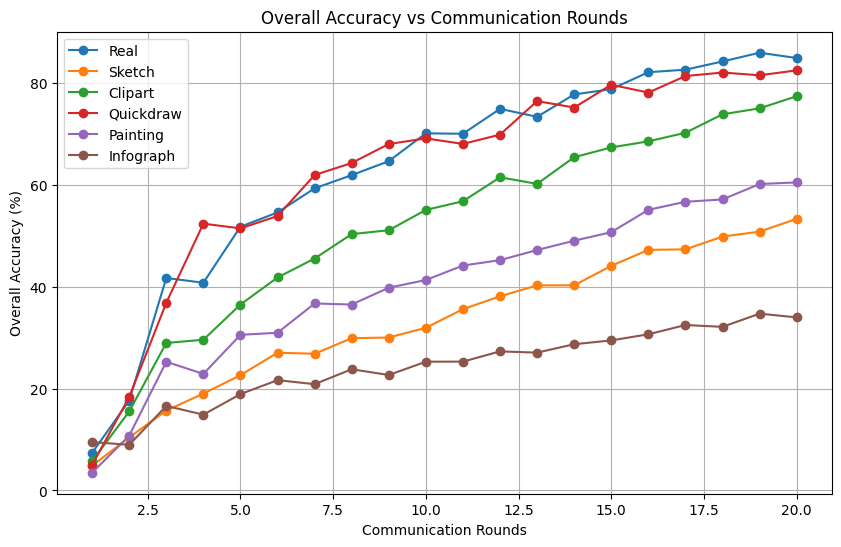

In [46]:
import matplotlib.pyplot as plt

# Extract data from test_accuracies
num_communication_rounds = len(test_accuracies)

# Plot Overall Accuracy vs num_communication_rounds
plt.figure(figsize=(10, 6))
real_overall = [test_accuracies[i]['real']['overall'] for i in range(num_communication_rounds)]
sketch_overall = [test_accuracies[i]['sketch']['overall'] for i in range(num_communication_rounds)]
clipart_overall = [test_accuracies[i]['clipart']['overall'] for i in range(num_communication_rounds)]
quickdraw_overall = [test_accuracies[i]['quickdraw']['overall'] for i in range(num_communication_rounds)]
painting_overall = [test_accuracies[i]['painting']['overall'] for i in range(num_communication_rounds)]
infograph_overall = [test_accuracies[i]['infograph']['overall'] for i in range(num_communication_rounds)]

plt.plot(range(1, num_communication_rounds + 1), real_overall, label='Real', marker='o')
plt.plot(range(1, num_communication_rounds + 1), sketch_overall, label='Sketch', marker='o')
plt.plot(range(1, num_communication_rounds + 1), clipart_overall, label='Clipart', marker='o')
plt.plot(range(1, num_communication_rounds + 1), quickdraw_overall, label='Quickdraw', marker='o')
plt.plot(range(1, num_communication_rounds + 1), painting_overall, label='Painting', marker='o')
plt.plot(range(1, num_communication_rounds + 1), infograph_overall, label='Infograph', marker='o')

plt.xlabel('Communication Rounds')
plt.ylabel('Overall Accuracy (%)')
plt.title('Overall Accuracy vs Communication Rounds')
plt.legend()
plt.grid(True)
plt.show()

# **Class Accuracies vs Number Communication Rounds**

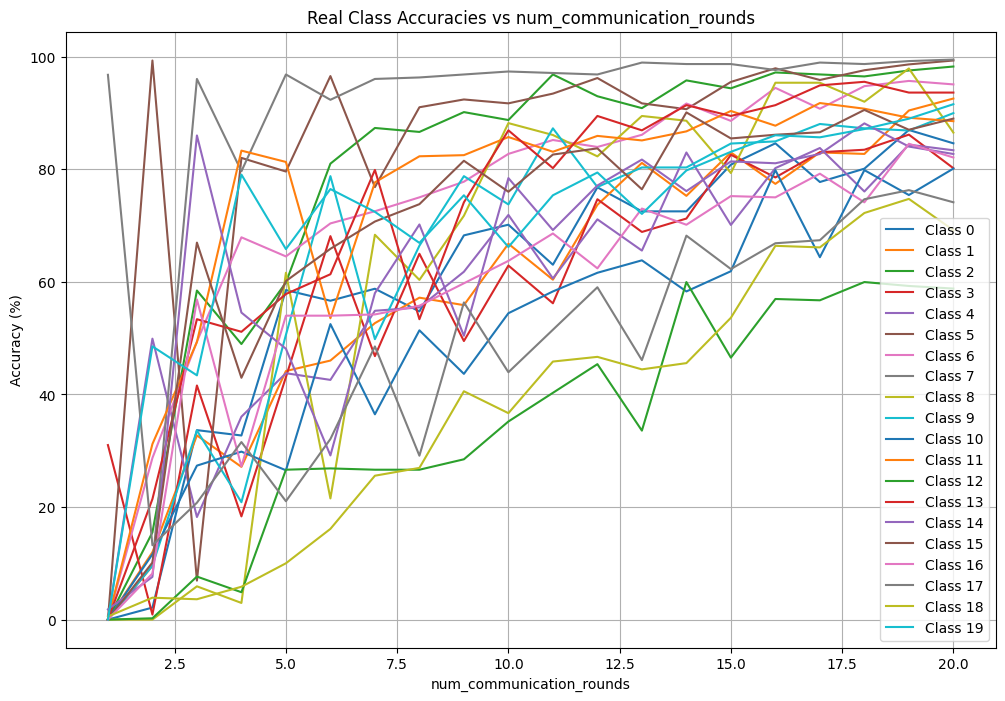

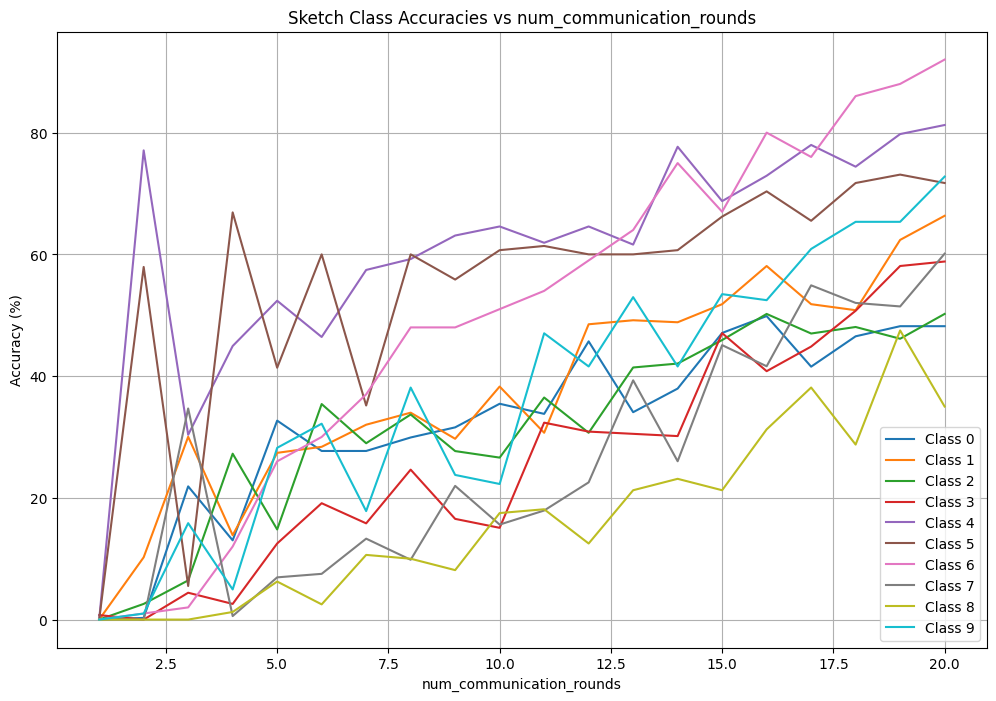

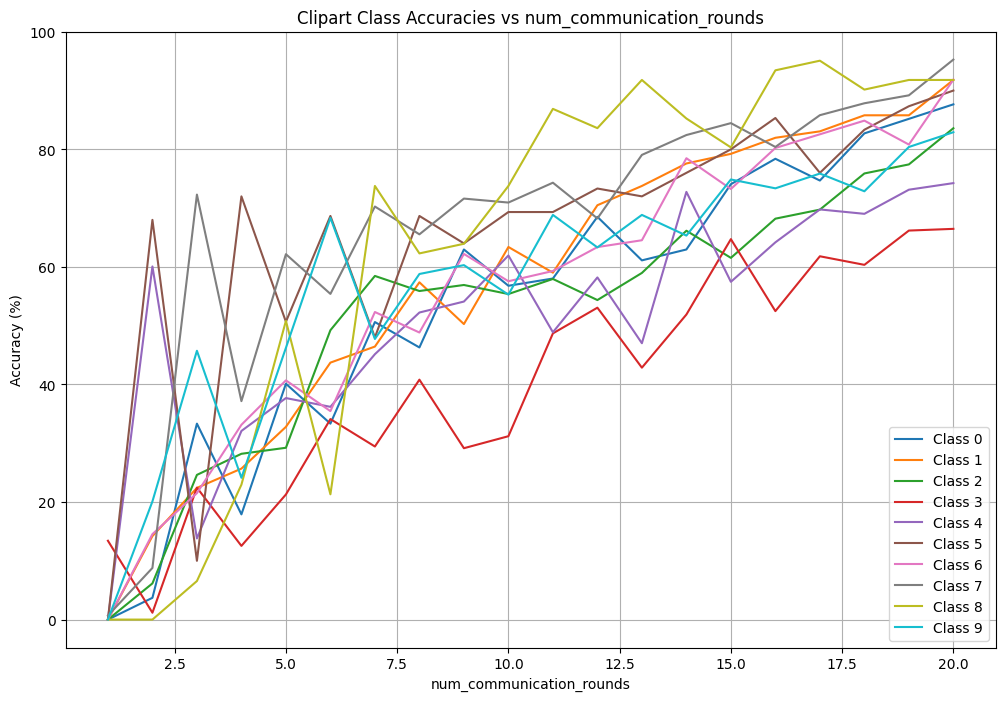

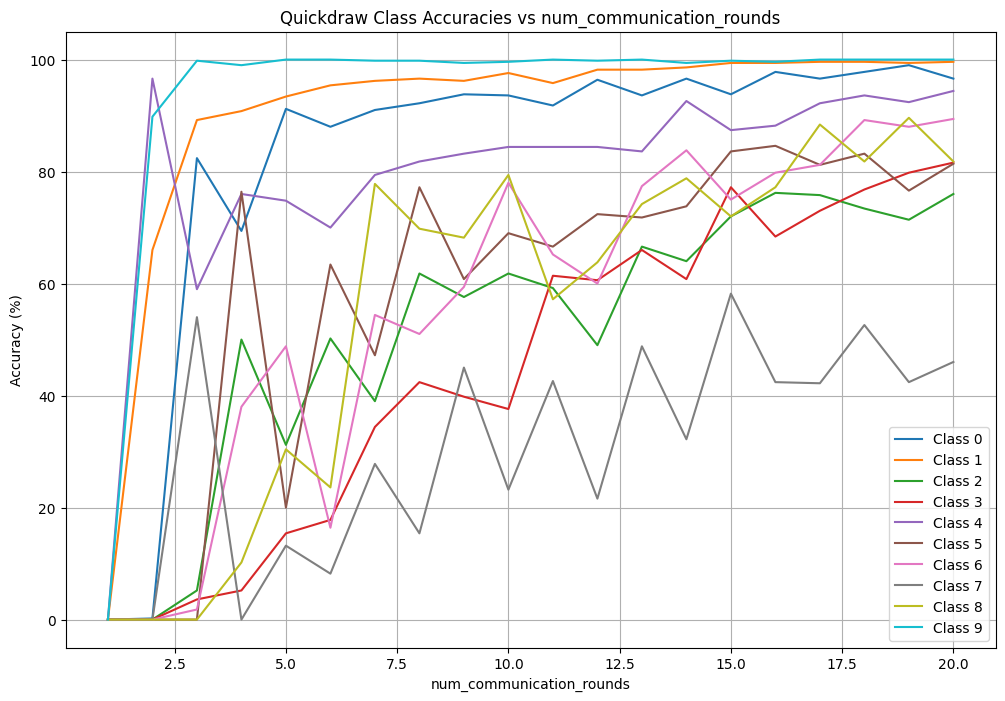

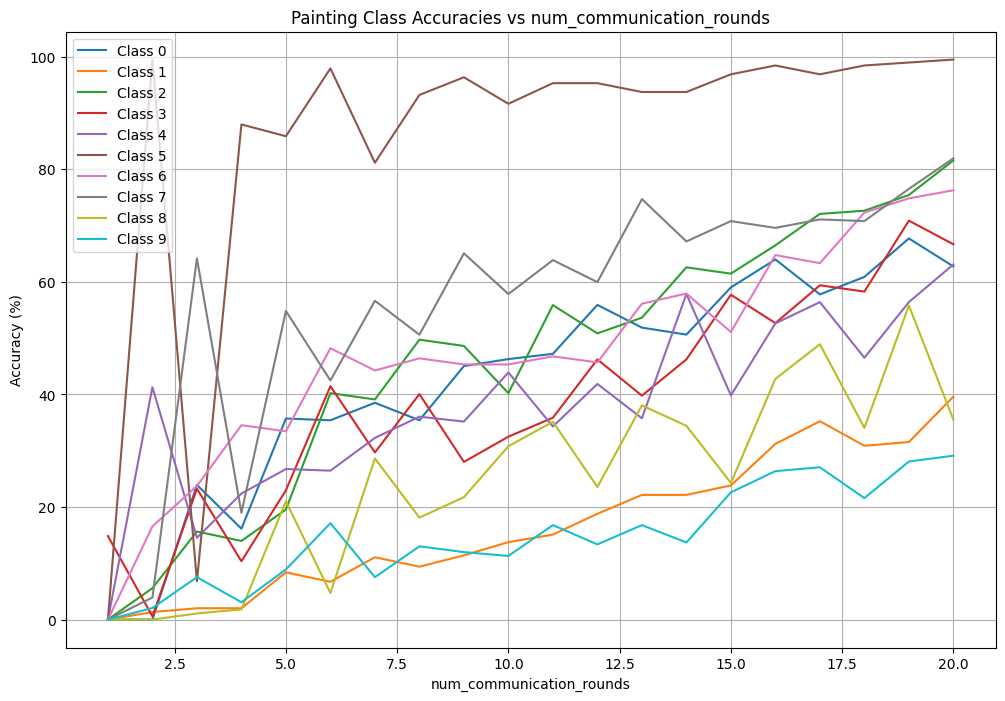

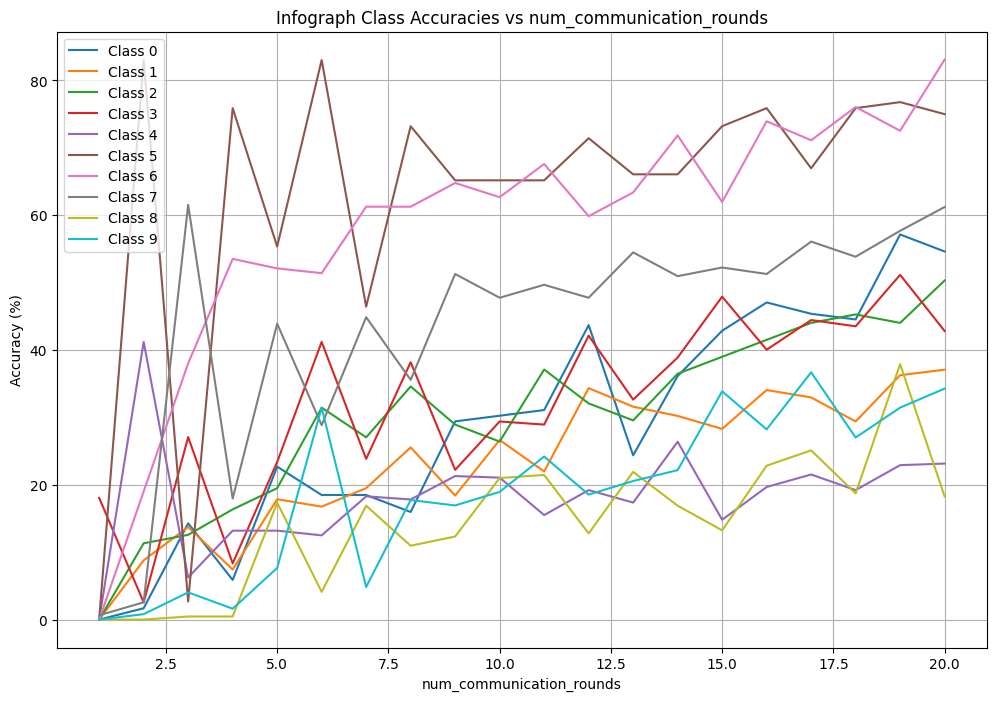

In [47]:
# Plot Class Accuracies vs num_communication_rounds for Real
plt.figure(figsize=(12, 8))
for cls in range(20):
    real_class_acc = [test_accuracies[i]['real']['class_acc'][cls] for i in range(num_communication_rounds)]
    plt.plot(range(1, num_communication_rounds + 1), real_class_acc, label=f'Class {cls}')

plt.xlabel('num_communication_rounds')
plt.ylabel('Accuracy (%)')
plt.title('Real Class Accuracies vs num_communication_rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plot Class Accuracies vs num_communication_rounds for Sketch
plt.figure(figsize=(12, 8))
for cls in range(10):
    sketch_class_acc = [test_accuracies[i]['sketch']['class_acc'][cls] for i in range(num_communication_rounds)]
    plt.plot(range(1, num_communication_rounds + 1), sketch_class_acc, label=f'Class {cls}')

plt.xlabel('num_communication_rounds')
plt.ylabel('Accuracy (%)')
plt.title('Sketch Class Accuracies vs num_communication_rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plot Class Accuracies vs num_communication_rounds for Clipart
plt.figure(figsize=(12, 8))
for cls in range(10):
    clipart_class_acc = [test_accuracies[i]['clipart']['class_acc'][cls] for i in range(num_communication_rounds)]
    plt.plot(range(1, num_communication_rounds + 1), clipart_class_acc, label=f'Class {cls}')

plt.xlabel('num_communication_rounds')
plt.ylabel('Accuracy (%)')
plt.title('Clipart Class Accuracies vs num_communication_rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plot Class Accuracies vs num_communication_rounds for Quickdraw
plt.figure(figsize=(12, 8))
for cls in range(10):
    quickdraw_class_acc = [test_accuracies[i]['quickdraw']['class_acc'][cls] for i in range(num_communication_rounds)]
    plt.plot(range(1, num_communication_rounds + 1), quickdraw_class_acc, label=f'Class {cls}')

plt.xlabel('num_communication_rounds')
plt.ylabel('Accuracy (%)')
plt.title('Quickdraw Class Accuracies vs num_communication_rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plot Class Accuracies vs num_communication_rounds for Painting
plt.figure(figsize=(12, 8))
for cls in range(10):
    painting_class_acc = [test_accuracies[i]['painting']['class_acc'][cls] for i in range(num_communication_rounds)]
    plt.plot(range(1, num_communication_rounds + 1), painting_class_acc, label=f'Class {cls}')

plt.xlabel('num_communication_rounds')
plt.ylabel('Accuracy (%)')
plt.title('Painting Class Accuracies vs num_communication_rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plot Class Accuracies vs num_communication_rounds for Infograph
plt.figure(figsize=(12, 8))
for cls in range(10):
    infograph_class_acc = [test_accuracies[i]['infograph']['class_acc'][cls] for i in range(num_communication_rounds)]
    plt.plot(range(1, num_communication_rounds + 1), infograph_class_acc, label=f'Class {cls}')

plt.xlabel('num_communication_rounds')
plt.ylabel('Accuracy (%)')
plt.title('Infograph Class Accuracies vs num_communication_rounds')
plt.legend()
plt.grid(True)
plt.show()


# **Saving Accuracies to a JSON File**

In [48]:
import json

# Convert tensors or non-serializable objects to plain Python types
test_accuracies_serializable = [
    {domain: {'overall': acc['overall'], 'class_acc': [float(ca) for ca in acc['class_acc']]}
     for domain, acc in round_acc.items()}
    for round_acc in test_accuracies
]

# Save as JSON
output_file = "/content/FedClassAvg_35DoubleDataset.json"
with open(output_file, "w") as f:
    json.dump(test_accuracies_serializable, f, indent=4)
print(f"Domain accuracies saved to {output_file}")

Domain accuracies saved to /content/FedClassAvg_35DoubleDataset.json
